# GROUND MOTION DIRECTIONALITY ANALYSIS FOR THE DESIGN AND ASSESSMENT OF STRUCTURES

This project aims to quantify the variability in the performance of structures to un certainty in seismic excitation direction. Within this setting, the project will provid engineers with practical recommendations and approximate methods by which grou d motion directionality is incorporated in design practice.

## 1. Problem statement

- **Objective**: 
  - Build the response spectrum for several earthquakes significant to the study. The earthquakes are extracted from the NGAWest2 ground motions (one component) db.
  - Model a real building. The ETSEIB will be used for this analysis.
  - Perform a modal analysis of the real building based on different spectral curves (Eurocode 8, ASCE, intensity measures, ...). Extract the displacement and acceleration at the roof.
  - Perform a Time History Analysis of the building to capture the displacement and acceleration at the roof for all possible angles of incidence of the earthquake.
  - Compare the Time History Analysis maximum results with the ones extracted from the modal analysis.
 
- **Expectations**:
  - Not all the intensity measures take into account the direction, so it would be expected that for some of the incidence angles the effects of the earthquake over the structure are bigger than the ones obtained with the design spectrum used.
  - When an earthquake is recorded with an accelerometer, the measures direction does not always give the biggest acceleration to the building. Usually N-S and E-W directions are taken, or the transversal and longitudinal ones in case of bridges. That must be taken into account in the design to avoid underestimating the effects of a seism.
  - A tradeoff between the probability of occurrence and the seismic risk and hazard on the collapse of a particular structure has to be made during the design.
  
- **References**:

  - Sections 1 and 3 from the book **Earthquake Dynamics of Structures** from the **Eartquake Engineering Research Institute EERI.**

## 2. Theoretical background

## 3. Simulation process

### 3.1. Required modules
Here there is the import of all required modules in this code. 

In [1]:
import openseespy.opensees as ops  # Opensees
import os  # to read files
import math
import numpy as np  #  multidimensional array and matrix data structures
import matplotlib.pyplot as plt  # to plot the data
import opsvis as opsv
import time as t
from tqdm import tqdm
import ipyparallel as ipp

### 3.2. Earthquake data extraction from NGA-West2

#### _Intro_

Here there is the explanation and code lines on how to extract the file data necessary to elaborate the RotD50 Response spectra of Tabas Earthquake.

From the Earthquake data (the flatfiles) it is known that the Tabas Eartquake in Iran recorded at 1978 at Tabas Station is the Record Sequence number 143 (RSN). With this number it is possible to extract the Ground Motion Data of this Earthquake.

9 different files are obtained. For each direction (horizontal and transversal in x-y plane, and vertical) can be obtained the data from acceleration, displacement and velocity.

In this code only the x (horizontal) and y (transversal) axis directions are of interest. Because with these two directions and their respective Ground Motion Data, and with $\theta$ angle, the important Ground Motion input can be obtained.

<img src="./img/2dim.png" alt="2dim" width="350" style="float: left;"/>

And with this the RotD50 Response Spectra can be ploted. 

<img src="./img/rotd50.png" alt="rotd50" width="350" style="float: left;"/>

#### _Explore ground motion data_

##### Files to read

In [2]:
#Define the path of the NGA-West2 files used
earthquakes_files = {
    'Tabas': {
        'GMD_longitudinal': './nga_west2_db/1_Tabas/tabas_RSN_143/RSN143_TABAS_TAB-L1.AT2',
        'GMD_transverse': './nga_west2_db/1_Tabas/tabas_RSN_143/RSN143_TABAS_TAB-T1.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Roermond_Netherlands': { 
        'GMD_longitudinal': './nga_west2_db/2_Roermond_Netherlands/RSN824_ROERMOND_WBS-EW.AT2',
        'GMD_transverse': './nga_west2_db/2_Roermond_Netherlands/RSN824_ROERMOND_WBS-NS.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'LA_Hollywood': { 
        'GMD_longitudinal': './nga_west2_db/4_LA/RSN46_LYTLECR_PEL090.AT2',
        'GMD_transverse': './nga_west2_db/4_LA/RSN46_LYTLECR_PEL180.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Nicaragua': { 
        'GMD_longitudinal': './nga_west2_db/3_Nicaragua/RSN95_MANAGUA_A-ESO090.AT2',
        'GMD_transverse': './nga_west2_db/3_Nicaragua/RSN95_MANAGUA_A-ESO180.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Italy_2': { 
        'GMD_longitudinal': './nga_west2_db/14_Italy2/RSN121_FRIULI.A_A-BCS000.AT2',
        'GMD_transverse': './nga_west2_db/14_Italy2/RSN121_FRIULI.A_A-BCS270.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Georgia': { 
        'GMD_longitudinal': './nga_west2_db/10_Georgia/RSN816_GEORGIA_AMB--X.AT2',
        'GMD_transverse': './nga_west2_db/10_Georgia/RSN816_GEORGIA_AMB--Y.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
    'Taiwan': { 
        'GMD_longitudinal': './nga_west2_db/6_Taiwan/RSN2790_CHICHI.04_HWA044E.AT2',
        'GMD_transverse': './nga_west2_db/6_Taiwan/RSN2790_CHICHI.04_HWA044N.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'Mexico': { 
        'GMD_longitudinal': './nga_west2_db/12_Mexico/RSN167_IMPVALL.H_H-CMP015.AT2',
        'GMD_transverse': './nga_west2_db/12_Mexico/RSN167_IMPVALL.H_H-CMP285.AT2',
        'spaces_numPoints': 3,
        'spaces_secs': 7
    },
     'Sulmona_Italy': { 
        'GMD_longitudinal': './nga_west2_db/13_Sulmona_Italy/RSN4490_L-AQUILA_BM444XTE.AT2',
        'GMD_transverse': './nga_west2_db/13_Sulmona_Italy/RSN4490_L-AQUILA_BM444YLN.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    },
    'Greece': { 
        'GMD_longitudinal': './nga_west2_db/9_Greece/RSN564_GREECE_H-KAL-NS.AT2',
        'GMD_transverse': './nga_west2_db/9_Greece/RSN564_GREECE_H-KAL-WE.AT2',
        'spaces_numPoints': 2,
        'spaces_secs': 6
    }
}

##### Function to read files

In [3]:
#Read the Ground Motion Data in the NGA-West2 files used
def read_NGAWest2_files(filepath, spaces_numPoints, spaces_secs):  
    """
    Read the NGAWest2 file
    
    Parameters
    ------------
    filepath : string
        location of the file
        
    Returns
    -------
    float
        dT diferential of time
    int
        number of point
    np.array
        list of ground motion acceleration
    """
    with open (filepath, "r") as GMfile:
        #put all the lines into a list
        data = GMfile.read().splitlines()
        
        #pick information from line 4 (there is the number of points and the df time differential)
        sp = data[3].split(' ')
        numPts = int(sp[spaces_numPoints].split(',')[0])
        dt = float(sp[spaces_secs])
        
        #remove headlines
        headlines = 4
        data = data[headlines:len(data)]
        
        #put acceleration data into list
        data = list(map(str.strip, data))
        data = list(map(str.split, data))
        gm = []
        for i in range(len(data)):
            for ind in range(len(data[i])):
                gm.append(float(data[i][ind]))
        
        return dt, numPts, np.array(gm)

##### Read files

In [4]:
import pickle
with open('earthquakes_data.txt', 'rb') as handle_earthquakes_data:
  earthquakes_data = pickle.loads(handle_earthquakes_data.read())

##### Plot Ground Motion Data

In [5]:
colors_scientific=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]

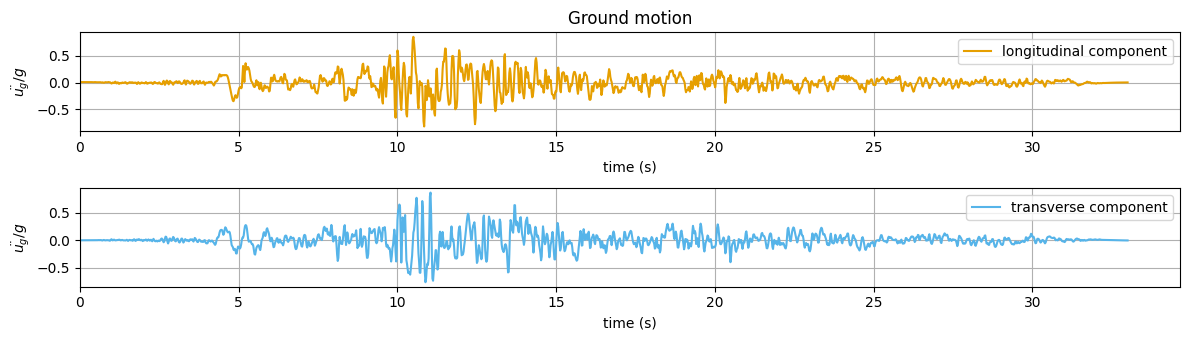

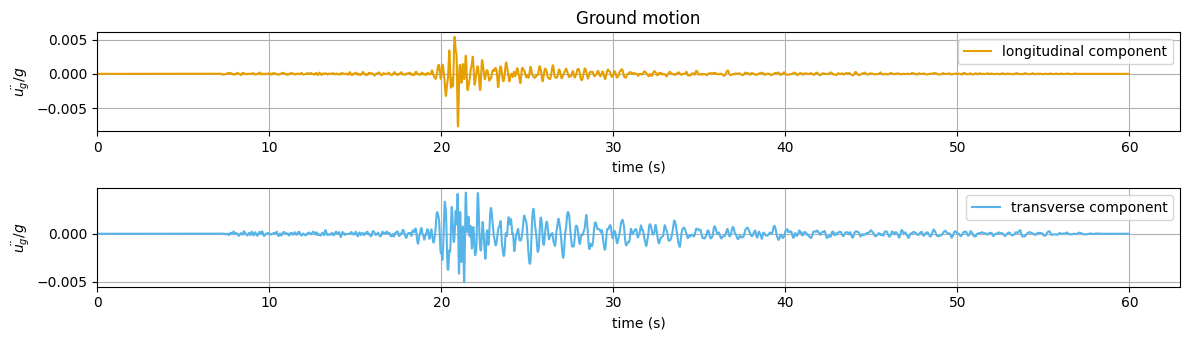

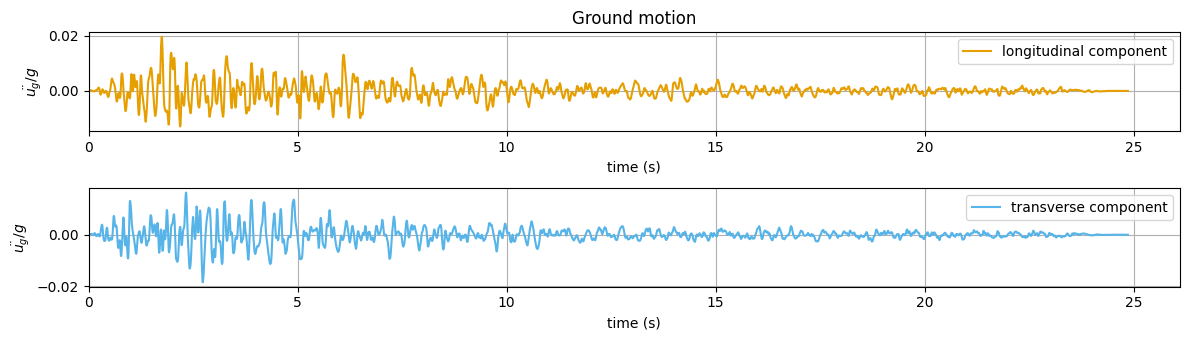

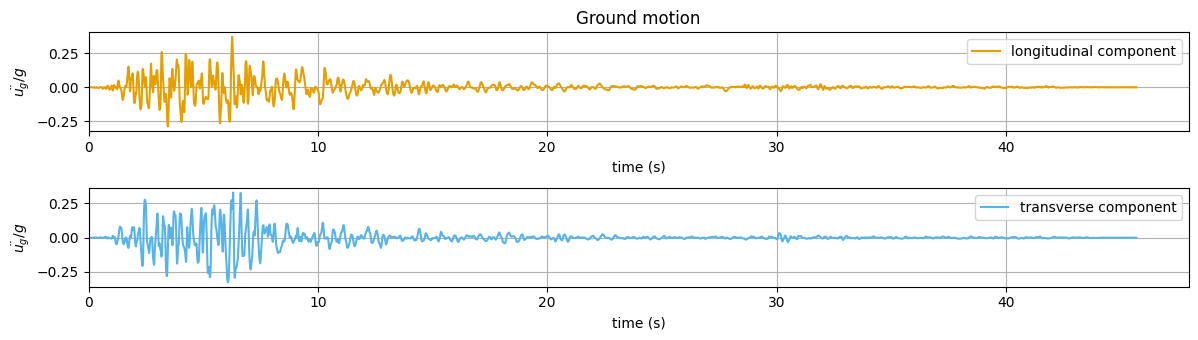

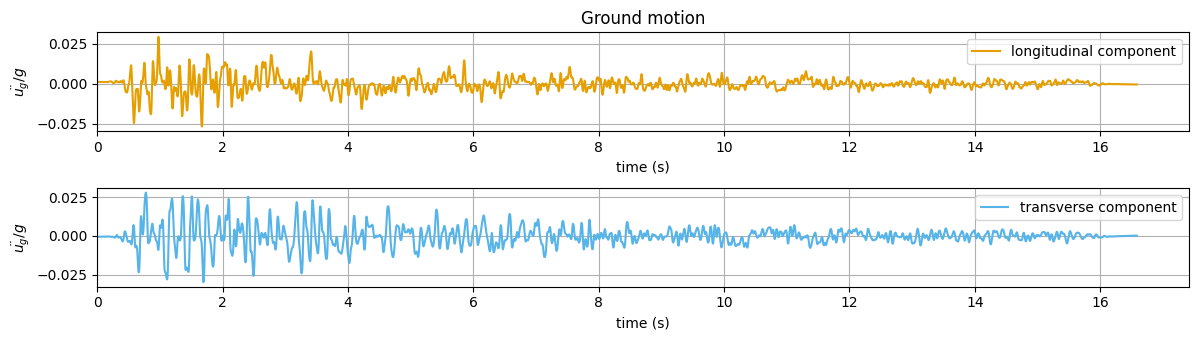

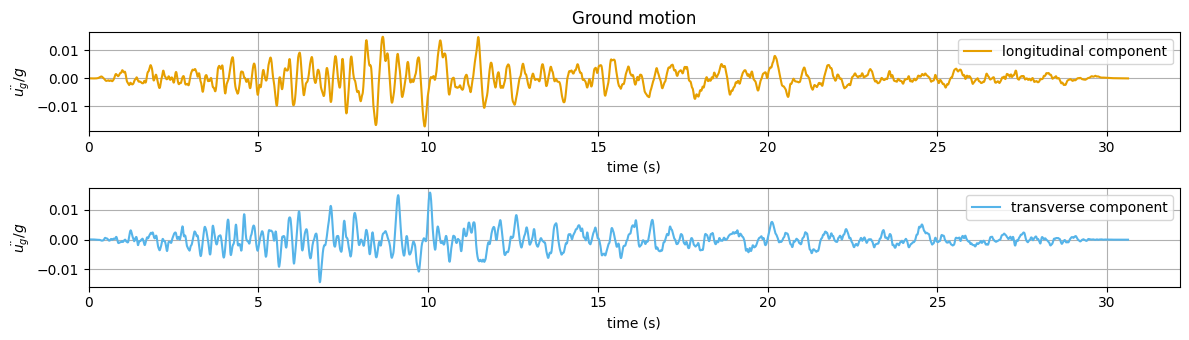

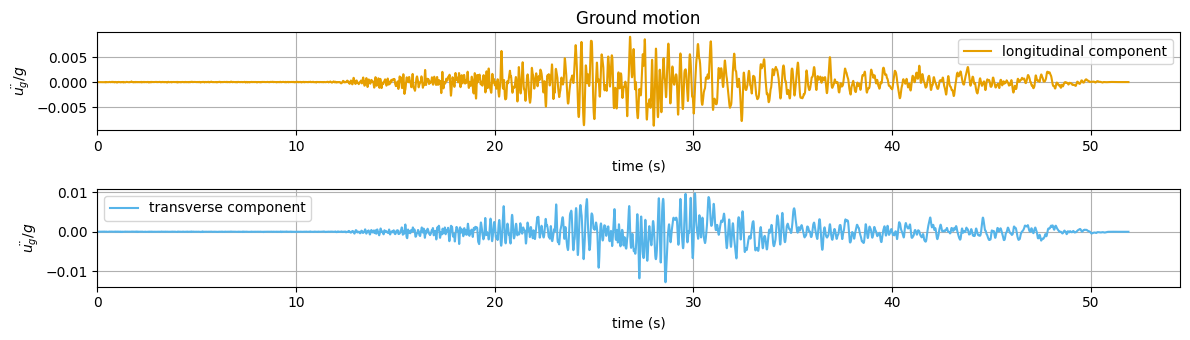

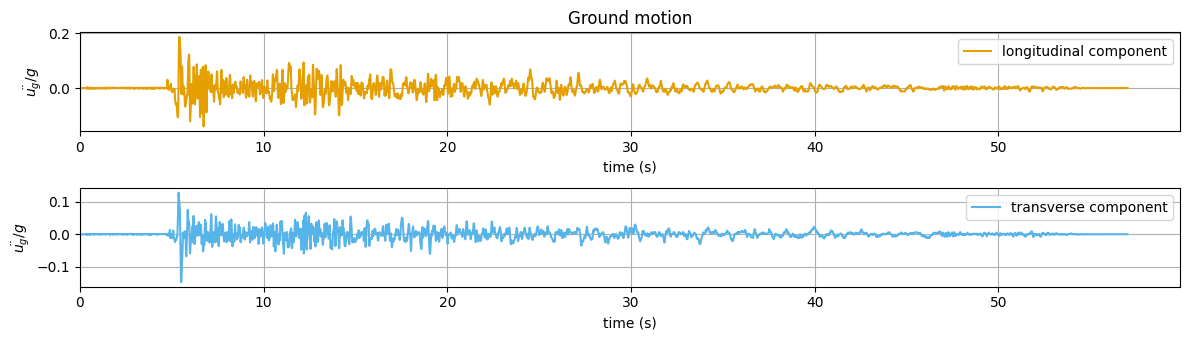

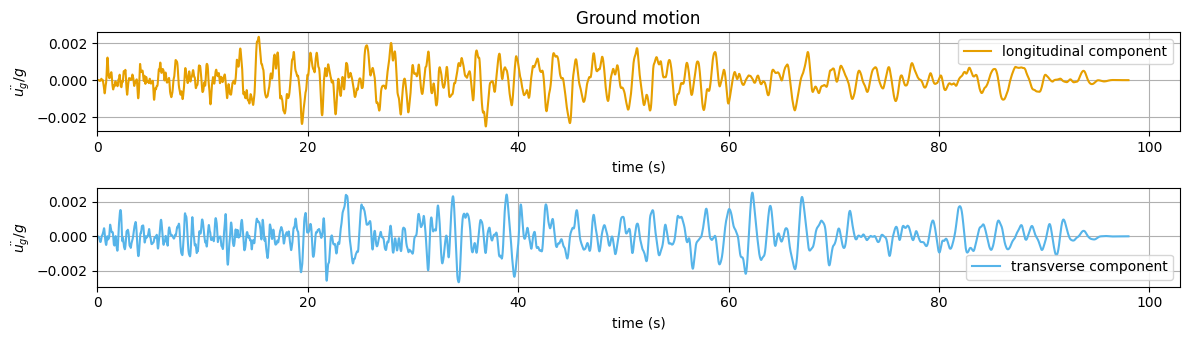

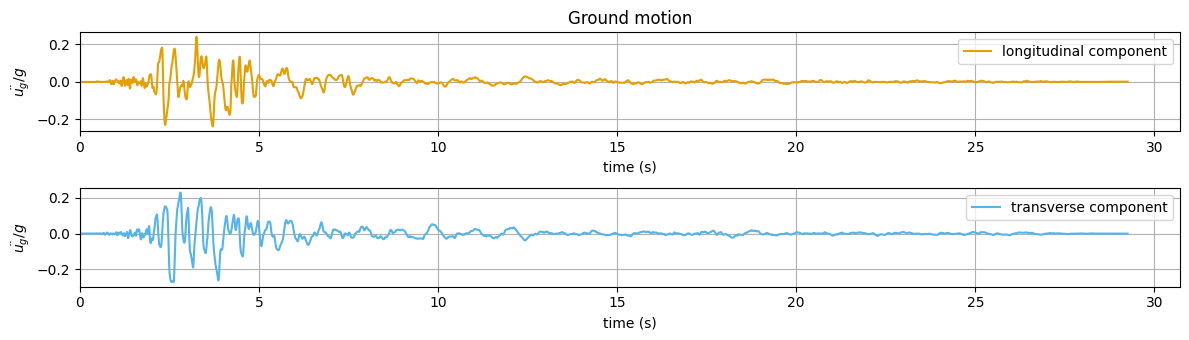

In [6]:
for earthquake in earthquakes_data:
    fig, (axs) = plt.subplots(2, 1, figsize=(12, 3.5))
    #axs[row].setp(ax1.get_xticklabels(),visible=False)
    axs[0].plot(earthquakes_data[earthquake]['GMD_longitudinal']['time'], earthquakes_data[earthquake]['GMD_longitudinal']['gmdata'], color='#E69F00', label='longitudinal component')
    axs[0].set(ylabel='$\ddot{u_g}/g$', xlabel='time (s)')
    axs[0].title.set_text('Ground motion')
    axs[0].grid()
    axs[0].set_xlim(left=0)
    axs[0].legend()
    
    axs[1].plot(earthquakes_data[earthquake]['GMD_transverse']['time'], earthquakes_data[earthquake]['GMD_transverse']['gmdata'], color='#56B4E9', label='transverse component')
    axs[1].set(ylabel='$\ddot{u_g}/g$', xlabel='time (s)')
    axs[1].grid()
    axs[1].set_xlim(left=0)
    axs[1].legend()
    
    fig.tight_layout(h_pad=1.0, w_pad=0.0)
    
    plt.savefig("./plots/Earthquakes/earthquake_{eth}_time.svg".format(eth=earthquake))
    plt.show()

#### _Find the combinational direction of Horitzontal Ground Motion + Transversal Ground Motion_

In [7]:
def create_aROT(aX, aY, theta):
    """
    Create a_ROT
    
    Parameters
    ------------
    aX : np.array
        horizontal acceleration
    aY : np.array
        transversal acceleration
    theta : int
        angle
    
    Returns
    -------
    np.array
        list of a_ROT
    """
    a_ROT = aX*math.cos(np.deg2rad(theta)) + aY*math.sin(np.deg2rad(theta))
    return a_ROT

##### Plot example for one angle and Earthquake

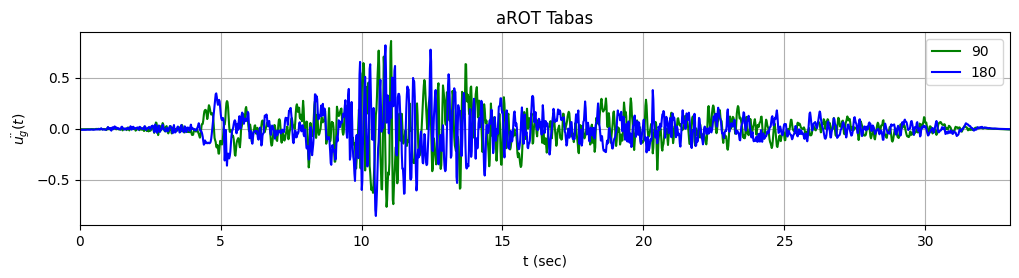

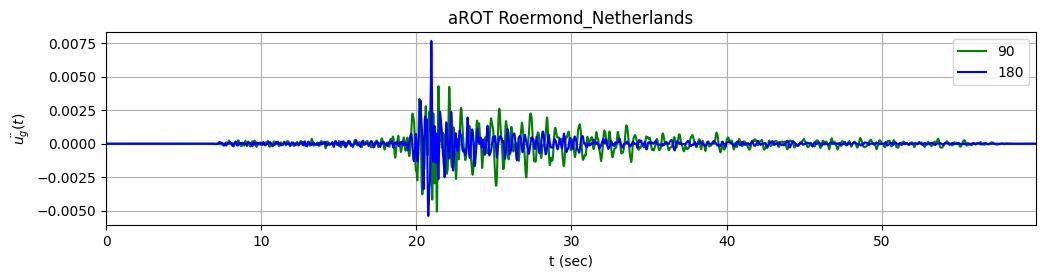

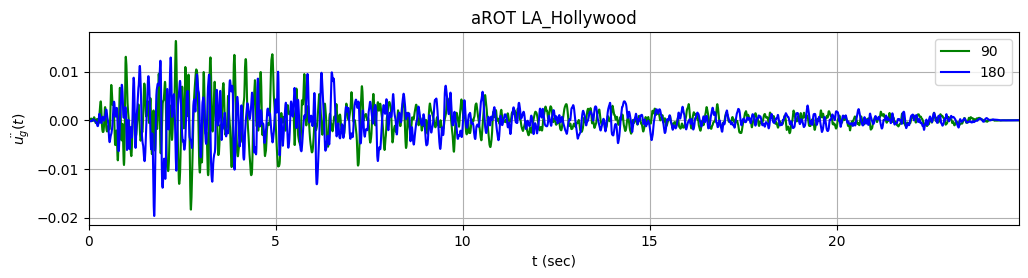

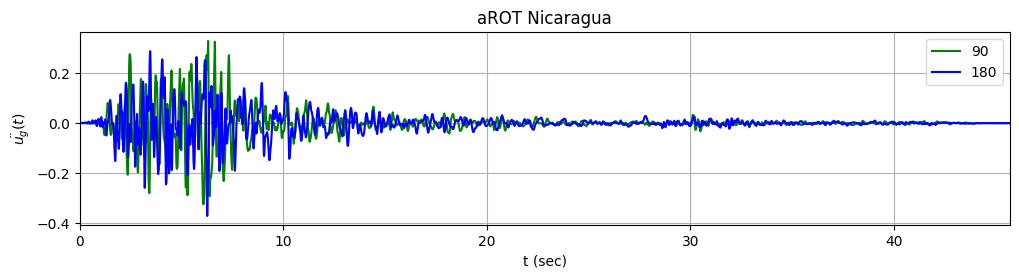

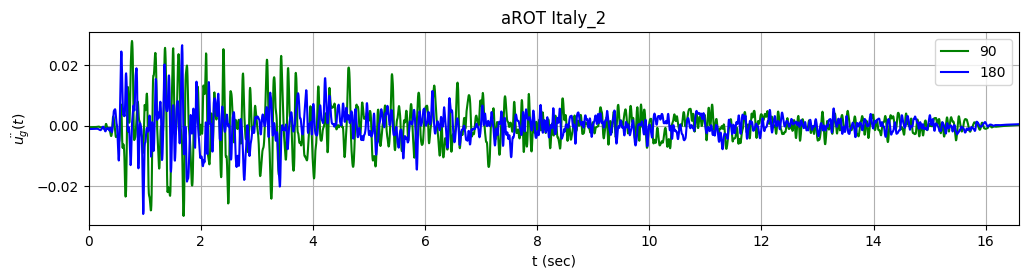

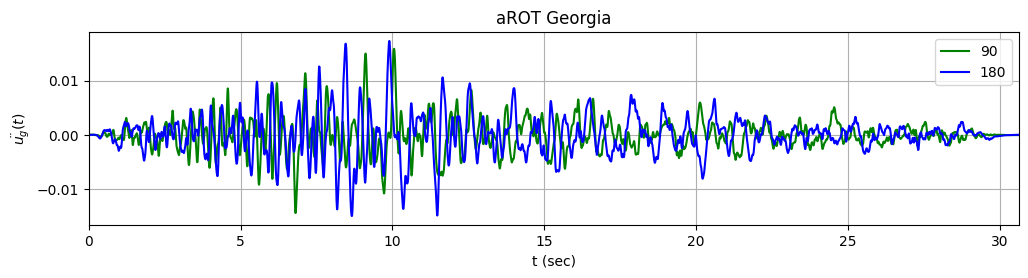

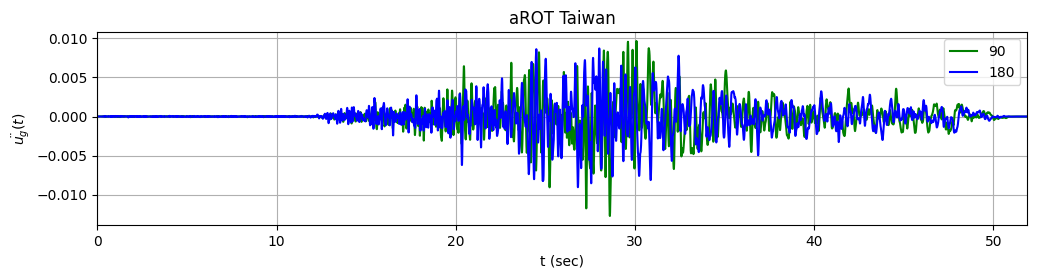

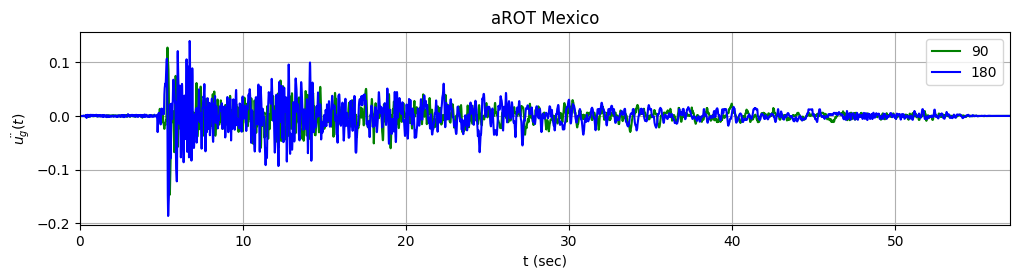

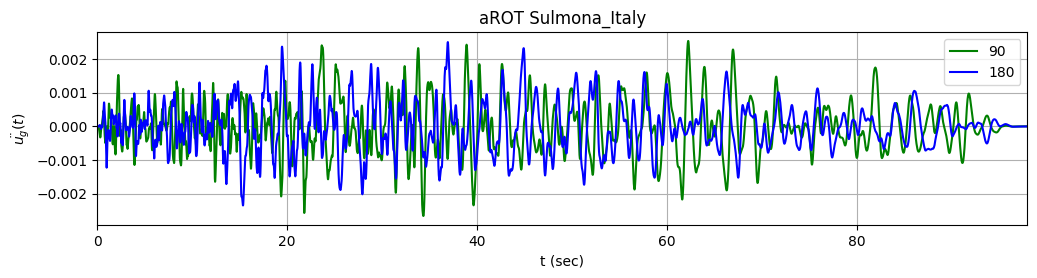

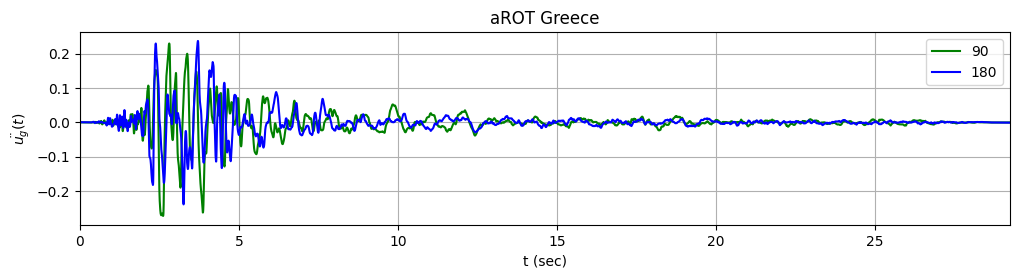

In [8]:
# Plot example of aROT for 90 and 180 degrees

for ethqke_name in earthquakes_files:
    arot_90 = create_aROT(earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'], 90)
    arot_180 = create_aROT(earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'], 180)
    
    plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'], arot_90, color='g', label='90')
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'], arot_180, color='b', label='180')
    plt.ylabel('$\ddot{u_g} (t)$')
    plt.xlabel('t (sec)')
    plt.title('aROT {eth}'.format(eth=ethqke_name))
    plt.grid()
    plt.xlim(left=0)
    plt.xlim(right=np.max(np.array(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'])))
    plt.legend()

    plt.savefig("./plots/Earthquakes/earthquake_{eth}_arot.svg".format(eth=ethqke_name))
    plt.show()

##### Create Rotation Angle Array

In [9]:
#Create Rotation Angle Array
d_theta = 1
initial_v = 0
final_v = 180 #degrees
N = (final_v - initial_v) / d_theta
theta_list = np.linspace(initial_v, final_v, num = int(N+1), endpoint=True)

### 3.3. Response Spectra

##### 3.3.1.2. SDOF analysis definition

In [21]:
damping = 0.05

responseSpectrumPeriods = np.linspace(0.1, 10, 75, endpoint=True)

import pickle
with open('IMs_dict.txt', 'rb') as handle_ims_dicts:
  IMs_dict = pickle.loads(handle_ims_dicts.read())

#### 3.3.4. Plot response spectras

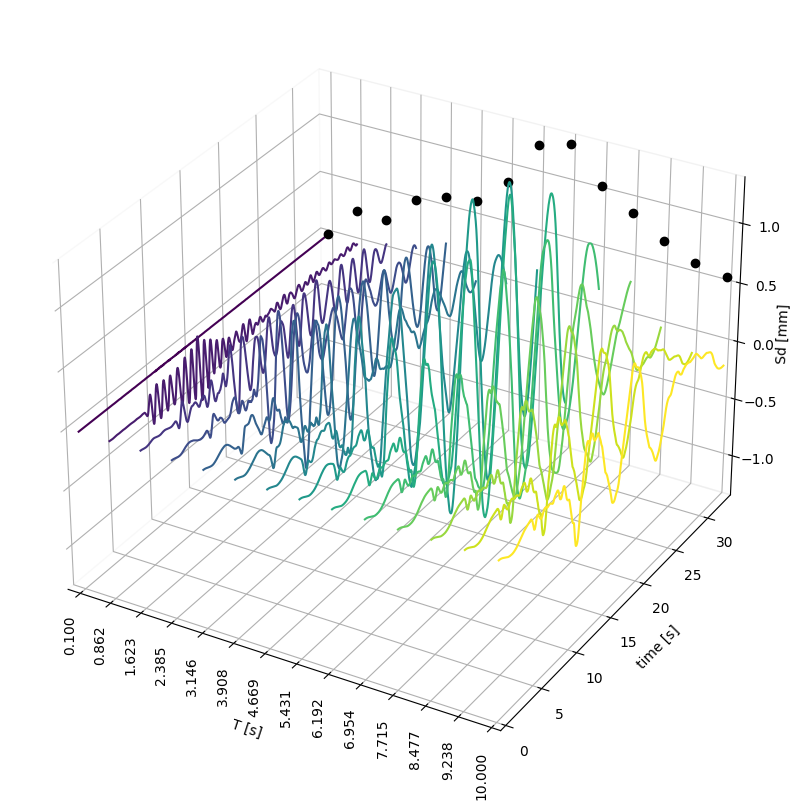

In [120]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=responseSpectrumPeriods[0], vmax=responseSpectrumPeriods[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)


fig = plt.figure('Parametric curve', figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
absMax = -20
absMin = 20
for i in range(len(responseSpectrumPeriods)):
    X = indexes[i][:-1]
    Y = earthquakes_data[earthquake]['GMD_longitudinal']['time']
    Z = results[i]['X'][magnitude][:-1] 
    ax.plot(X, Y, Z, color=scalarMap.to_rgba(responseSpectrumPeriods[i]))
    maxValue = np.max(np.array(results[i]['X'][magnitude]))
    if maxValue > absMax:
        absMax = maxValue
    if np.min(np.array(results[i]['X'][magnitude])) < absMin:
        absMin = np.min(np.array(results[i]['X'][magnitude]))
    ax.plot(responseSpectrumPeriods[i], earthquakes_data[earthquake]['GMD_longitudinal']['time'][-1], maxValue, marker="o", color='k')

ax.set_xticks(responseSpectrumPeriods)
ax.set_xlabel('T [s]',labelpad=15)
ax.set_xlim(0, responseSpectrumPeriods[-1])
ax.set_ylabel('time [s]')
ax.set_ylim(0, earthquakes_data[earthquake]['GMD_longitudinal']['time'][-1])
ax.set_zlabel('Sd [mm]', labelpad=-0.8)
ax.set_zlim(absMin, absMax)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
plt.xticks(rotation=90)
plt.savefig("./plots/RS/RS.svg")
plt.show()

In [38]:
# Init SRSS combination structure
earthquakes_SRSS_combination = {}
for earthquake in earthquakes_data:
    earthquakes_SRSS_combination[earthquake] = {}
    for n in range(len(nodes_left_side)):
        earthquakes_SRSS_combination[earthquake][nodes_left_side[n]] = {
            'Ux': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Uy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vx': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ax': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ay': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            } 
        }

# Fill initialized structure wth the SRSS combination method
for earthquake in earthquakes_data:
    for n in range(len(nodes_left_side)):
        for key in earthquakes_SRSS_combination[earthquake][nodes_left_side[n]]:
            for i in range(modesToStudy):
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD100'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD50'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD00'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['SRSS'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Max'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['X'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Y'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Geomean'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8_design'], 2)
                earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'] += math.pow(earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['asce'], 2)
                
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD100'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD50'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['RotD00'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['SRSS'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Max'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['X'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Y'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Geomean'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'])*1e6
            earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'] = math.sqrt(earthquakes_SRSS_combination[earthquake][nodes_left_side[n]][key]['asce'])*1e6
        

In [39]:
earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]['Ux']['Eurocode8_design']

15.768764989717113

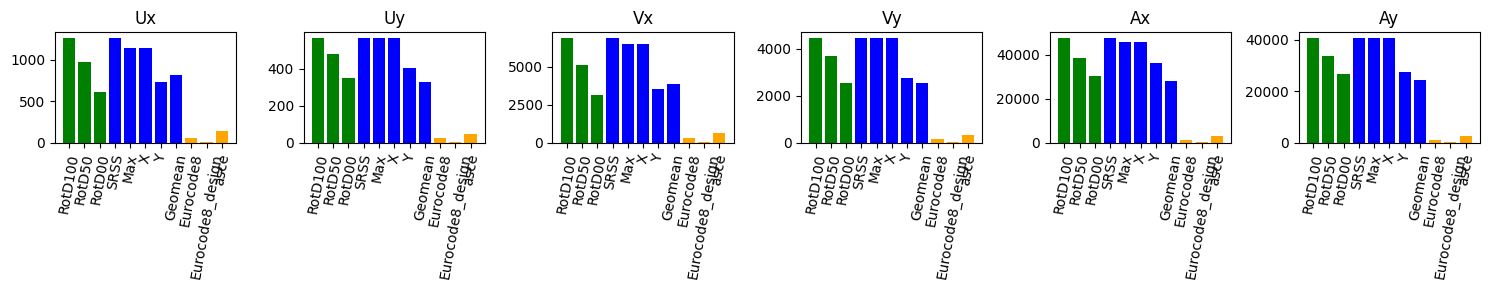

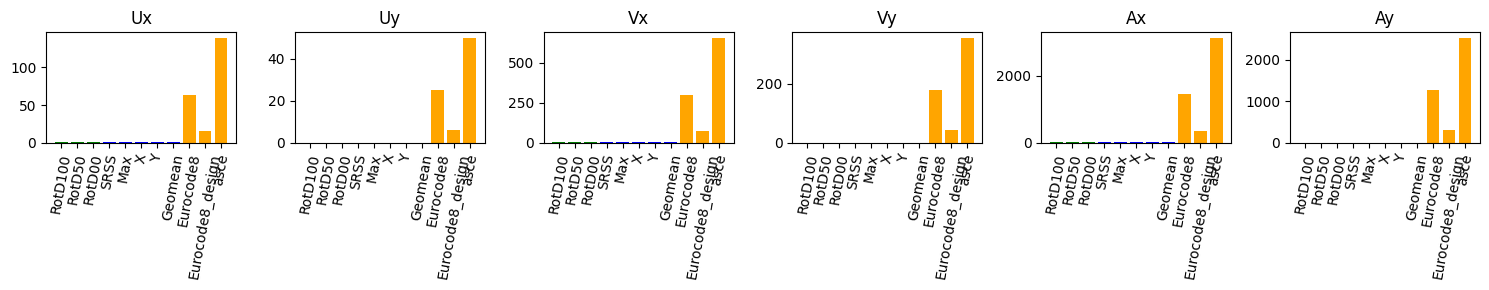

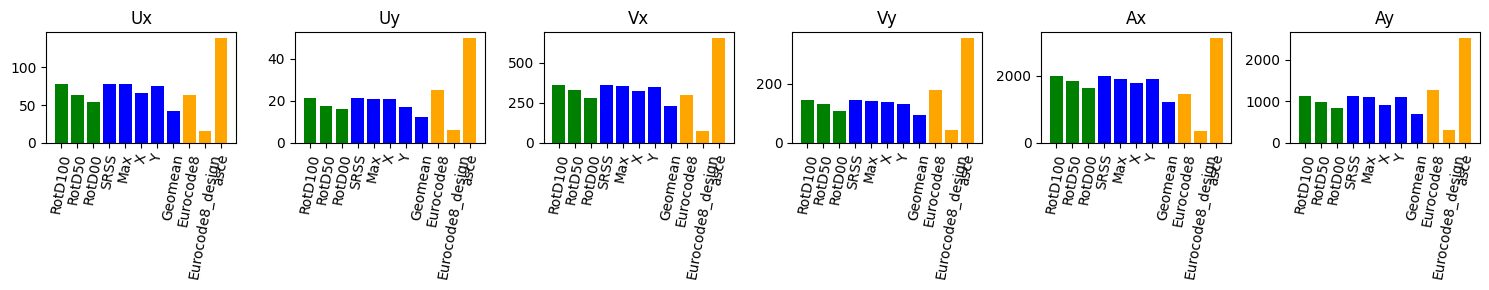

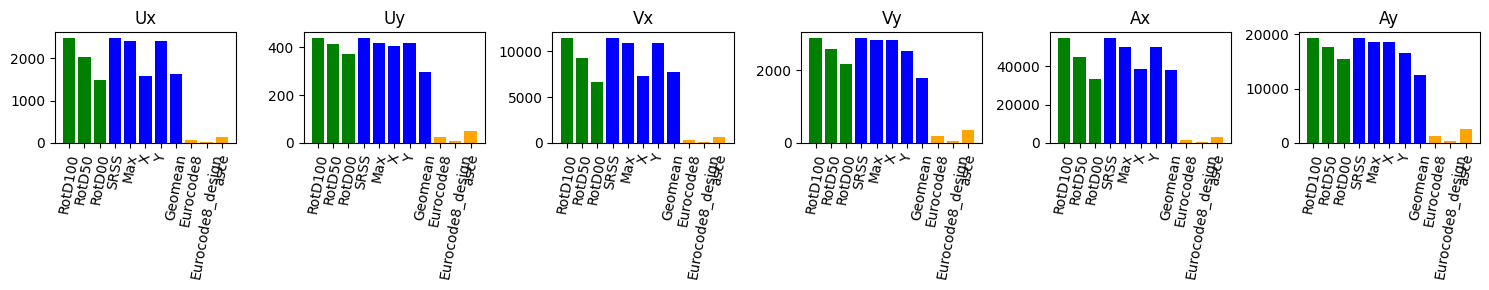

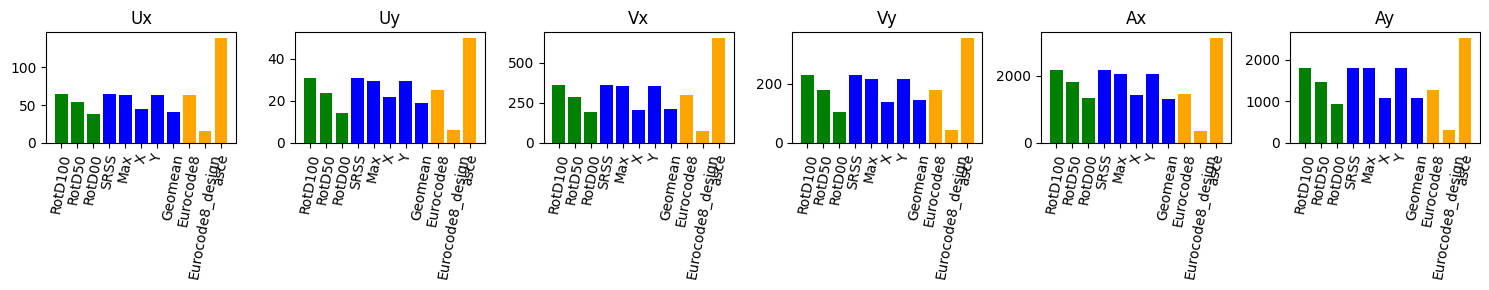

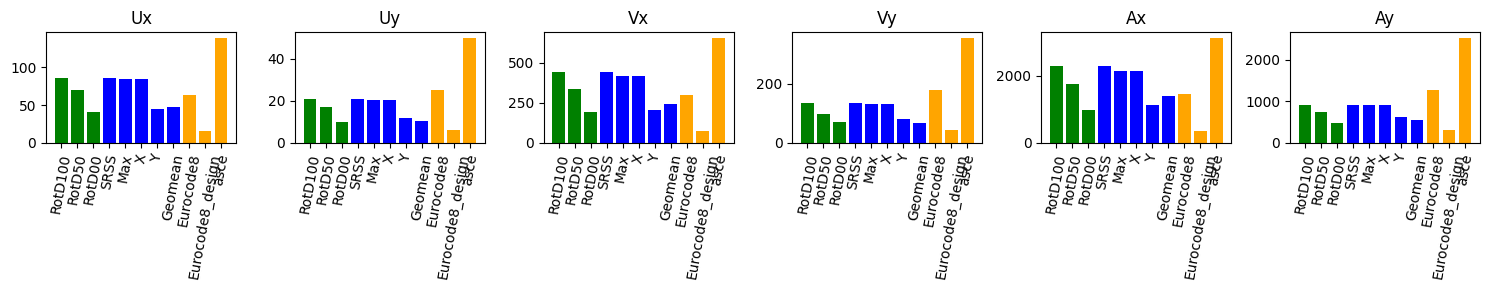

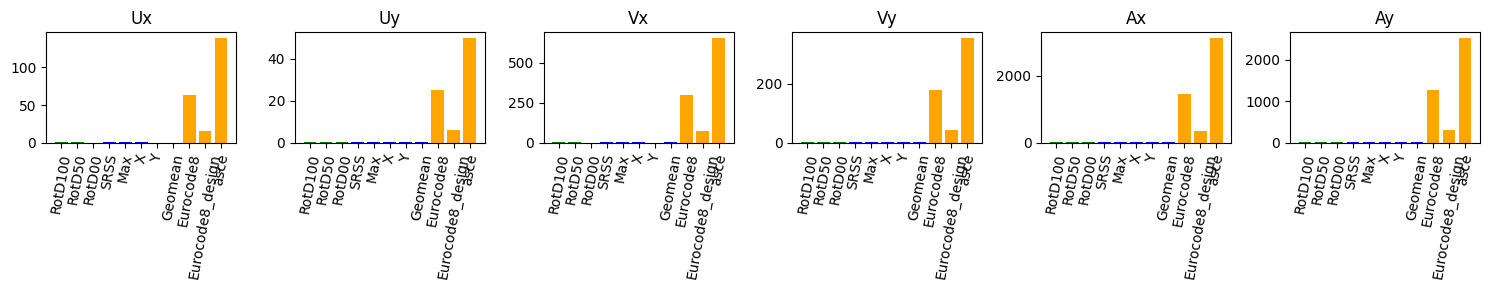

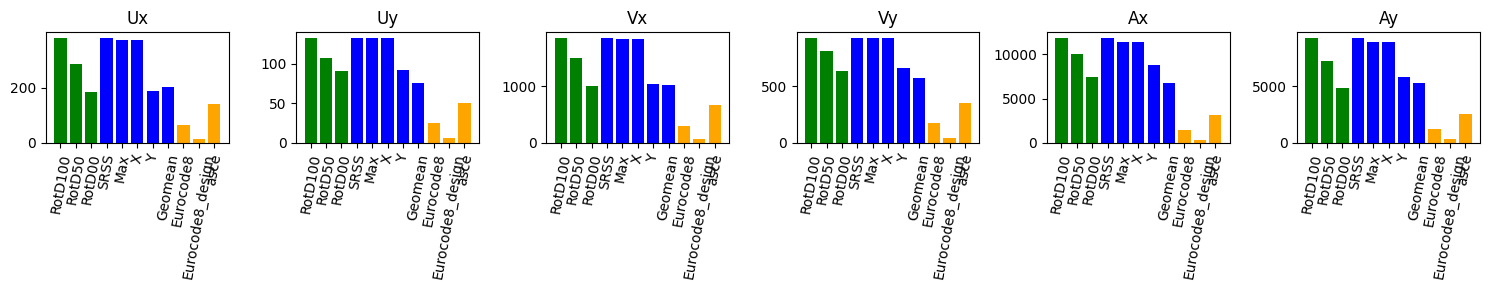

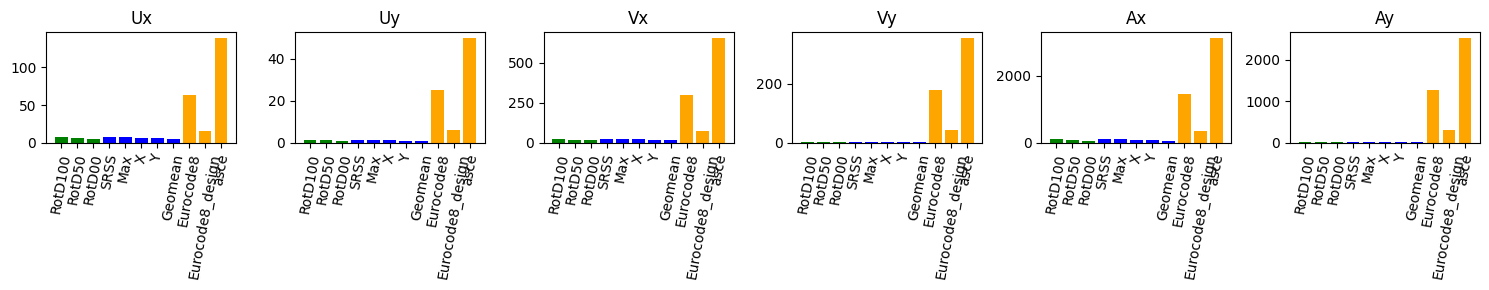

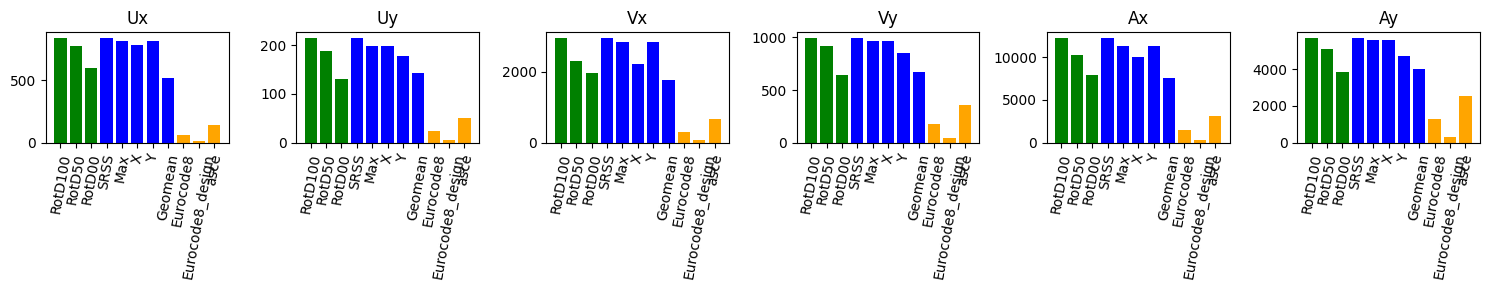

In [40]:
# Barplot of the ROOF displacements for each of the IMs

for earthquake in earthquakes_modal_analysis:
    fig, (axs) = plt.subplots(1, 6, figsize=(15,3))
    col = 0
    for magnitude in earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[col].bar(xPos, y_values, color = colors)
        plt.sca(axs[col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[col].title.set_text(magnitude)
        
        col += 1

    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig("./plots/SRSS/SRSS_{eth}.svg".format(eth=earthquake))    
    plt.show()

In [41]:
# Init CQC combination structure
earthquakes_CQC_combination = {}
for earthquake in earthquakes_data:
    earthquakes_CQC_combination[earthquake] = {}
    for n in range(len(nodes_left_side)):
        earthquakes_CQC_combination[earthquake][nodes_left_side[n]] = {
            'Ux': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Uy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vx': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Vy': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ax': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            },
            'Ay': {
                'RotD100': 0.0,
                'RotD50': 0.0,
                'RotD00': 0.0,
                'SRSS': 0.0,
                'Max': 0.0,
                'X': 0.0,
                'Y': 0.0,
                'Geomean': 0.0,
                'Eurocode8': 0.0,
                'Eurocode8_design': 0.0,
                'asce': 0.0
            } 
        }

# Fill initialized structure wth the SRSS combination method
for earthquake in earthquakes_data:
    for n in range(len(nodes_left_side)):
        for key in earthquakes_CQC_combination[earthquake][nodes_left_side[n]]:
            for i in range(modesToStudy):
                for m in range(modesToStudy):
                    betaim = (2*math.pi/Period_mode_i[i]) / (2*math.pi/Period_mode_i[m])#wi/wm
                    pim = (math.pow(damping, 2)*math.pow(1+betaim, 2))/(math.pow(1-betaim, 2) + 4*math.pow(damping, 2)*betaim)
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD100'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD100']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD50'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD50']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['RotD00'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['RotD00']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['SRSS'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['SRSS']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Max'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Max']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['X'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['X']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Y'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Y']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Geomean'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Geomean']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['Eurocode8_design'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8_design']
                    earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'] += pim * earthquakes_modal_analysis[earthquake][i+1][nodes_left_side[n]][key]['asce'] * earthquakes_modal_analysis[earthquake][m+1][nodes_left_side[n]][key]['Eurocode8_design']
                
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'])*1e6
            earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'] = math.sqrt(earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'])*1e6

            if 'y' in key:
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD100']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD50']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['RotD00']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['SRSS']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Max']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['X']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Y']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Geomean']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['Eurocode8_design']
                earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce'] = earthquakes_CQC_combination[earthquake][nodes_left_side[n]][key]['asce']
                
            

In [42]:
earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]['Ux']['Eurocode8_design']

18.081020747270767

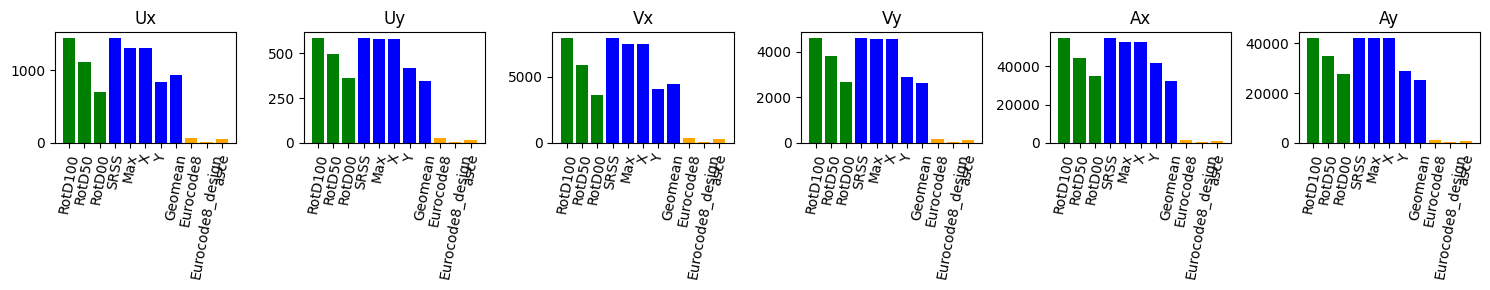

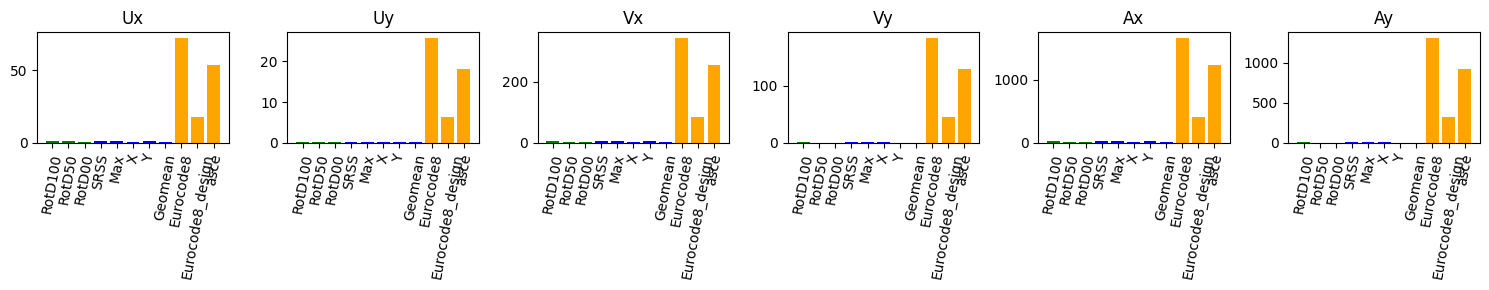

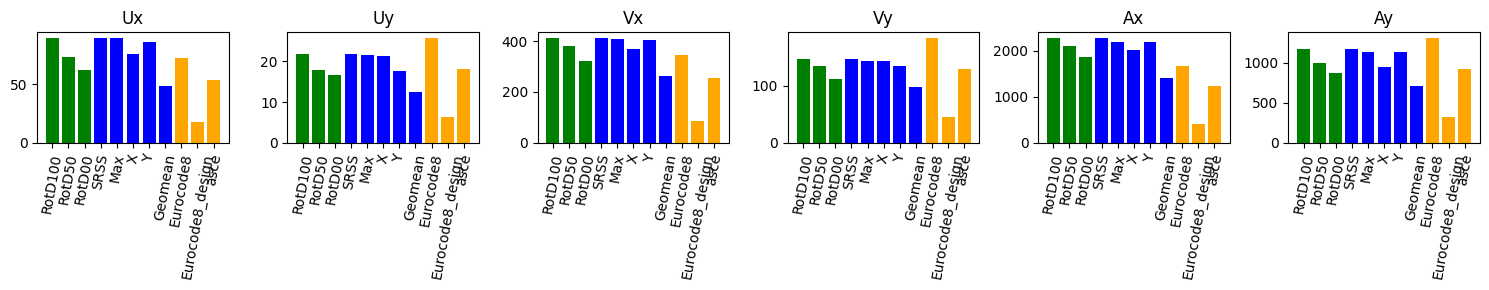

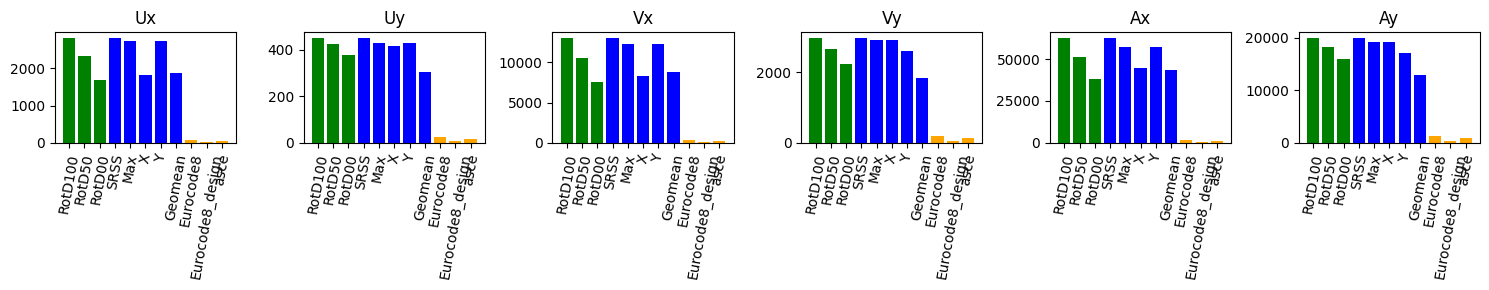

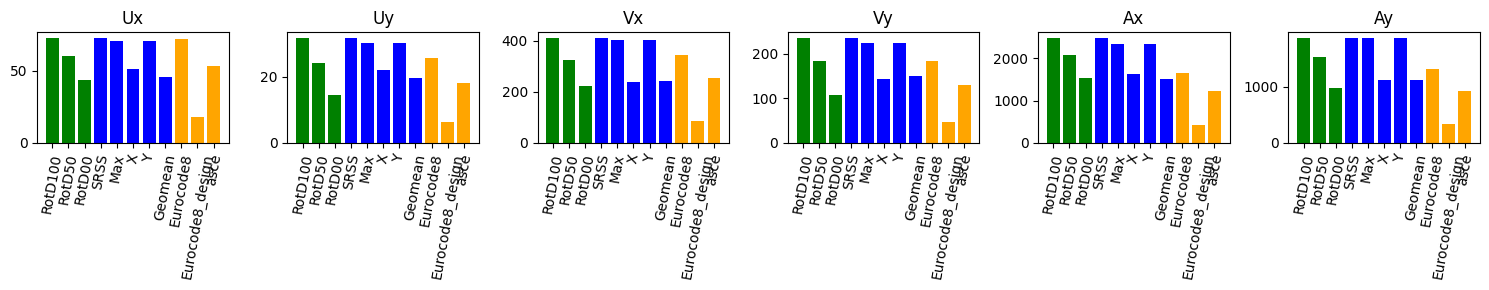

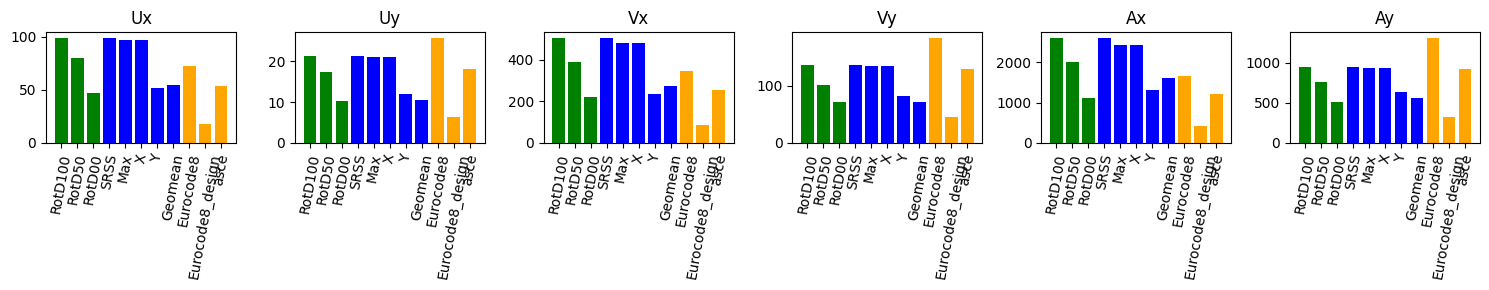

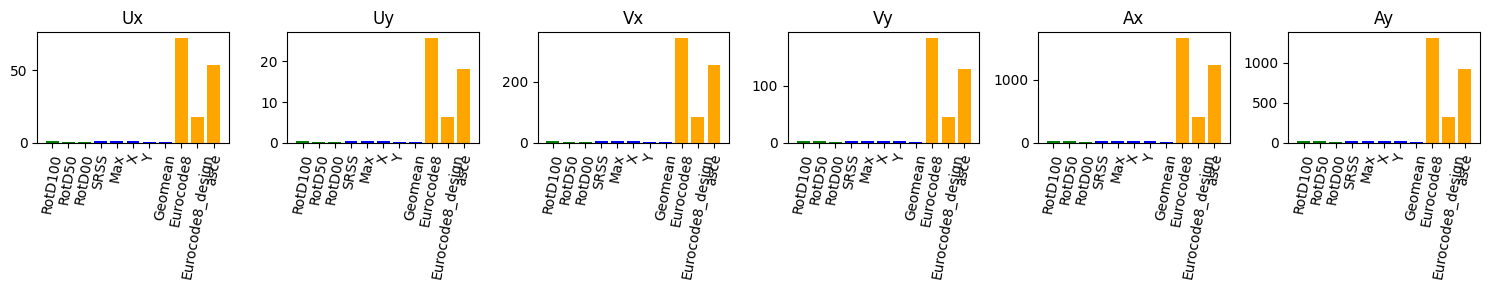

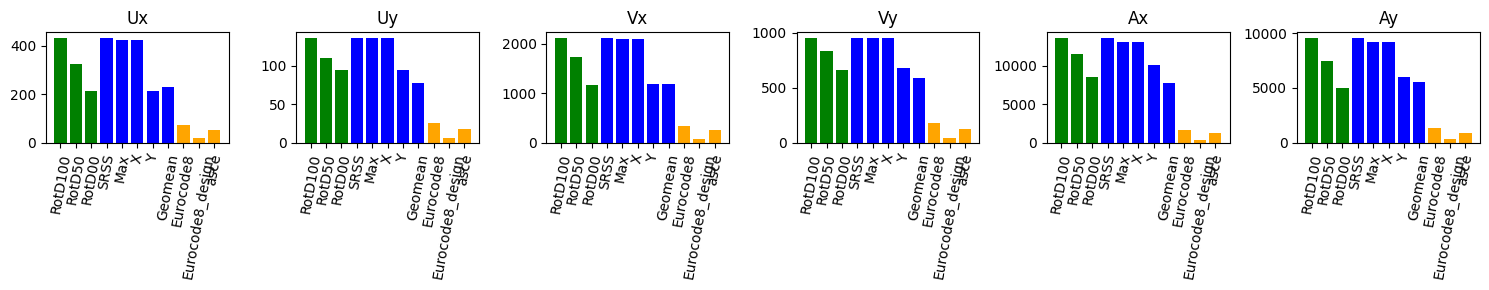

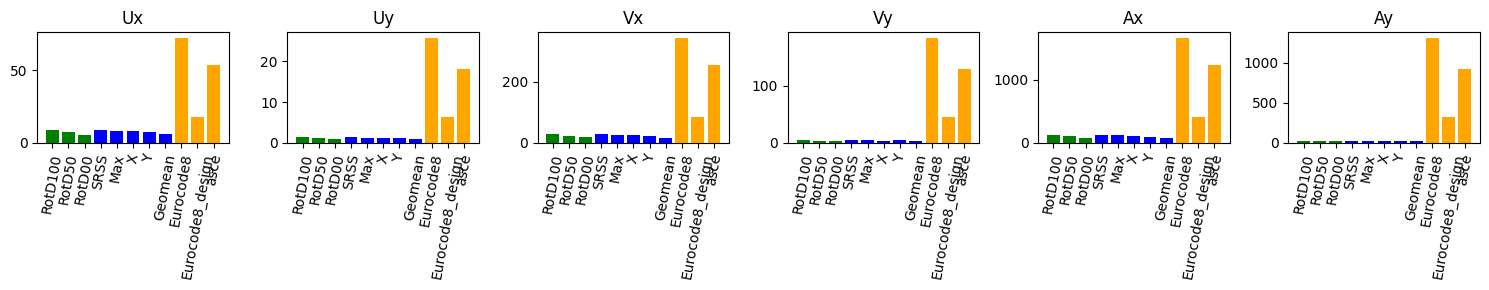

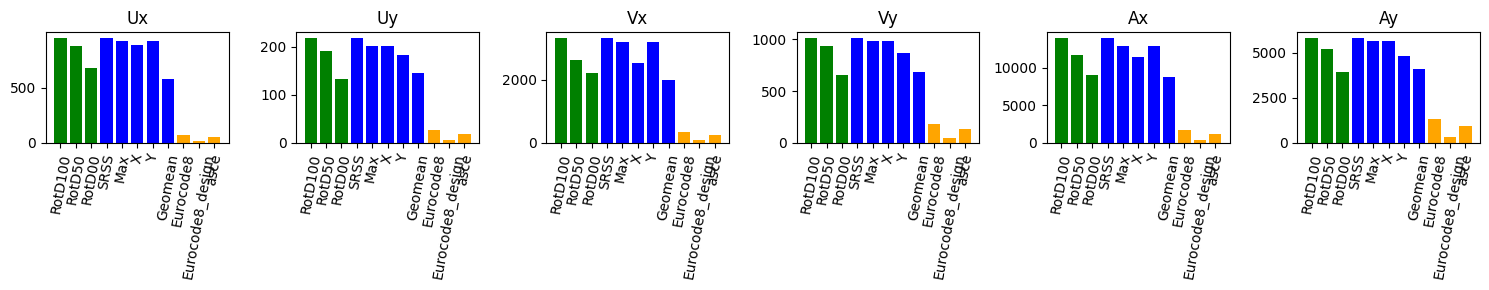

In [43]:
# Barplot of the ROOF displacements for each of the IMs
for earthquake in earthquakes_modal_analysis:
    fig, (axs) = plt.subplots(1, 6, figsize=(15,3))
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[col].bar(xPos, y_values, color = colors)
        plt.sca(axs[col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[col].title.set_text(magnitude)
        
        col += 1
        
    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig("./plots/CQC/CQC_{eth}.svg".format(eth=earthquake))   
    plt.show()

In [44]:
## COMPARE SRSS with CQC

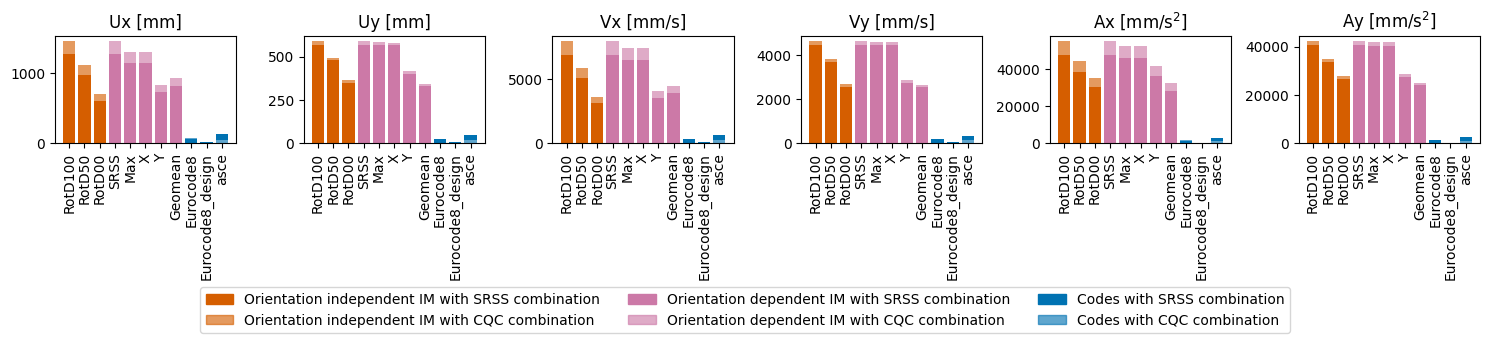

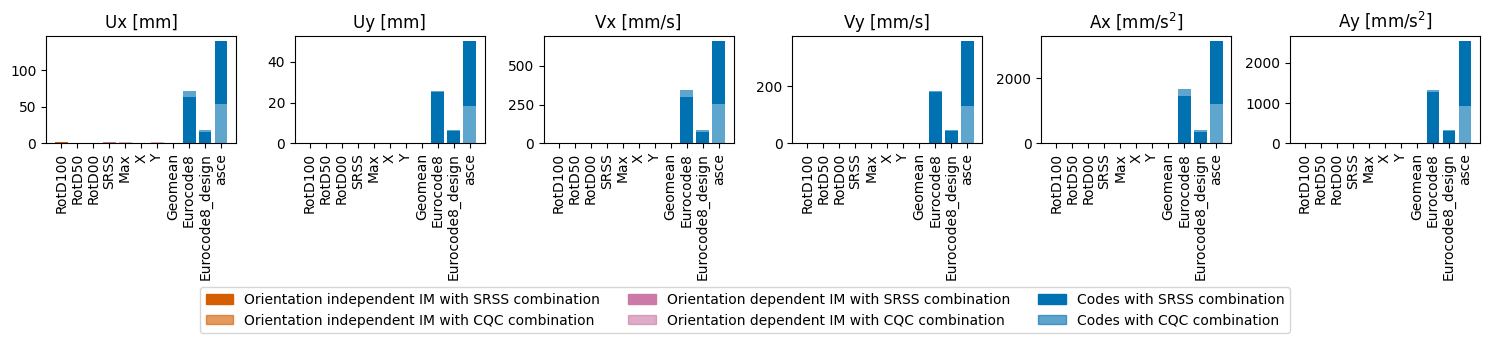

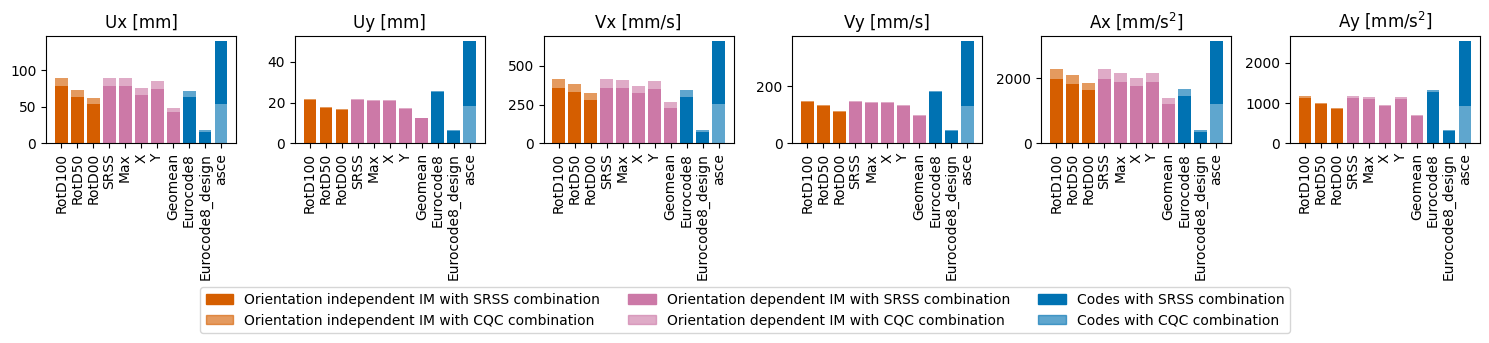

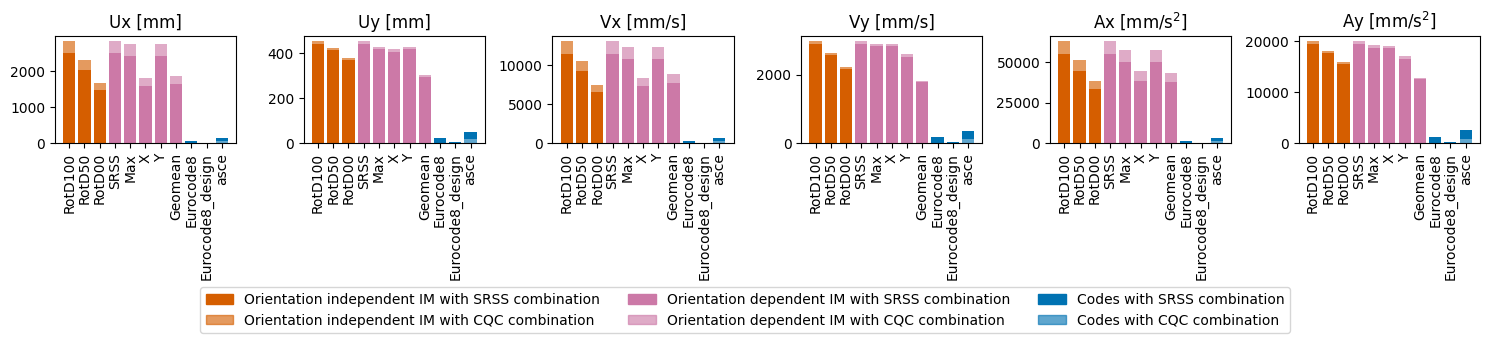

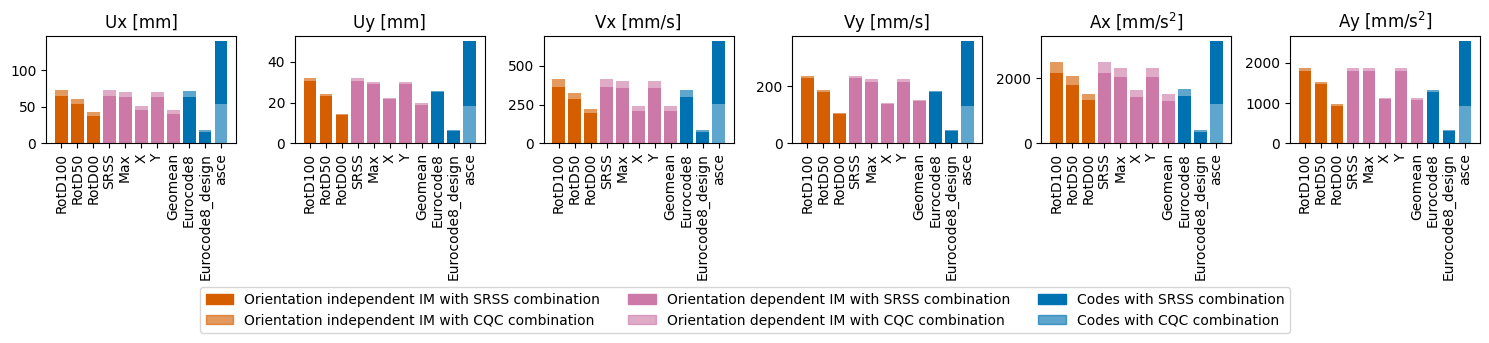

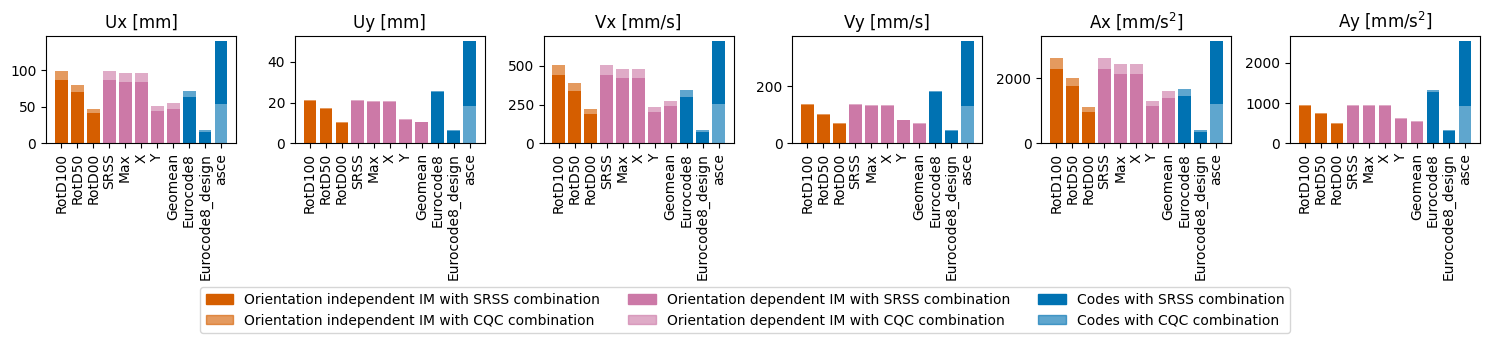

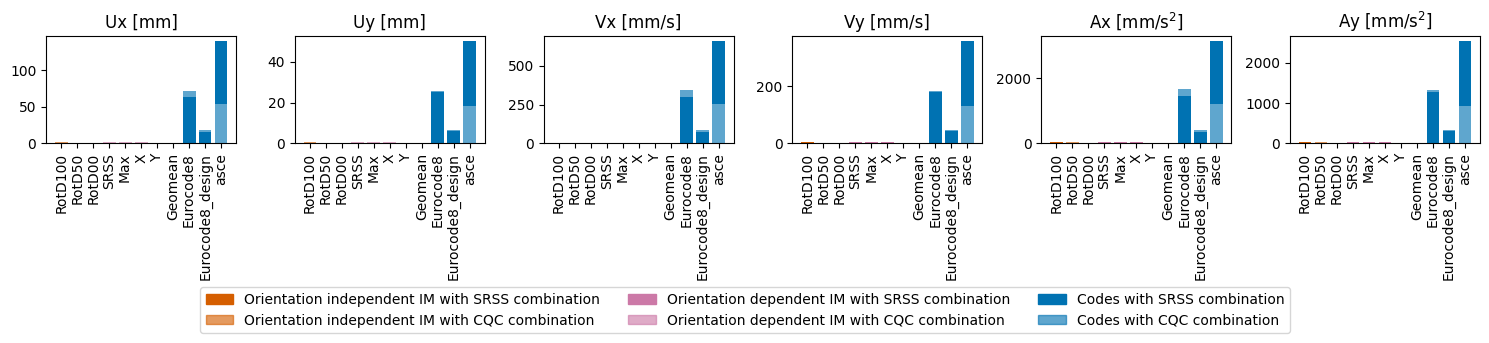

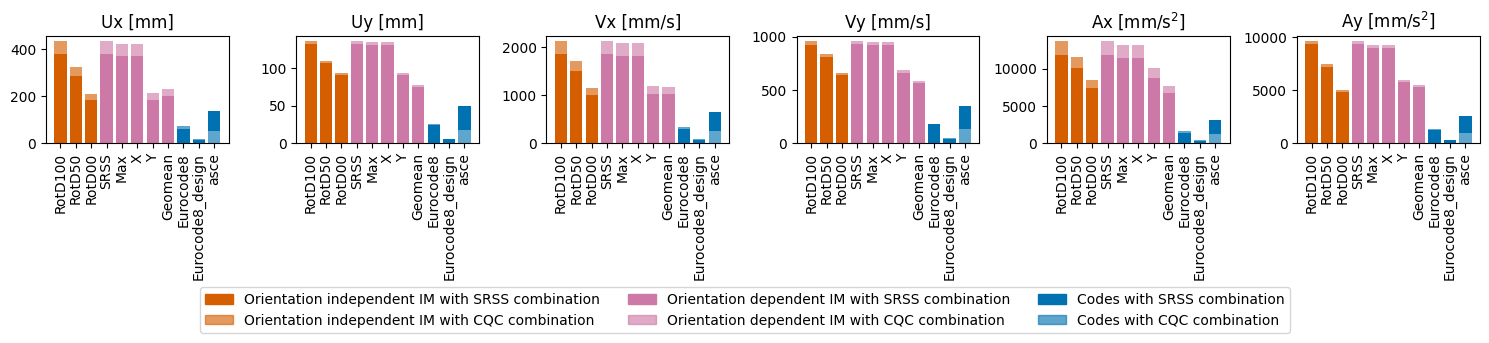

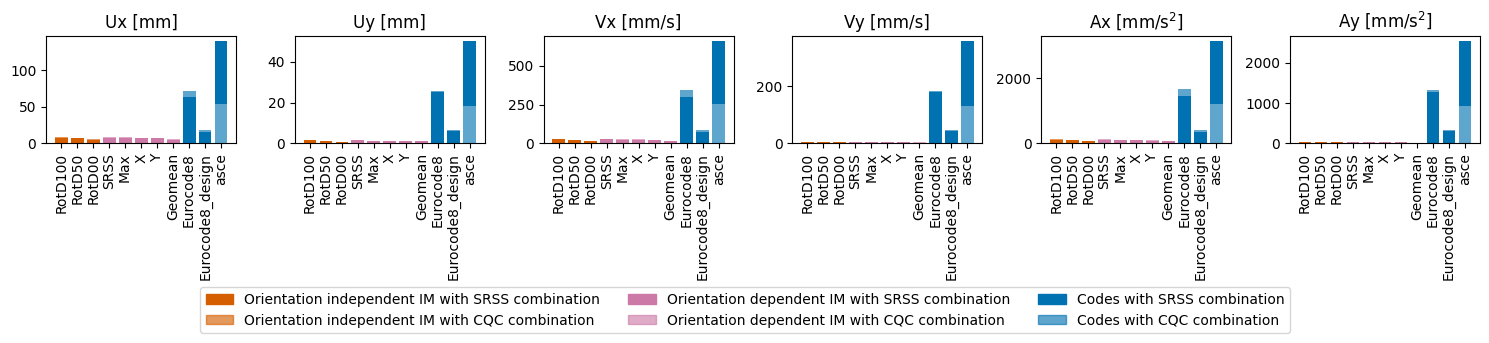

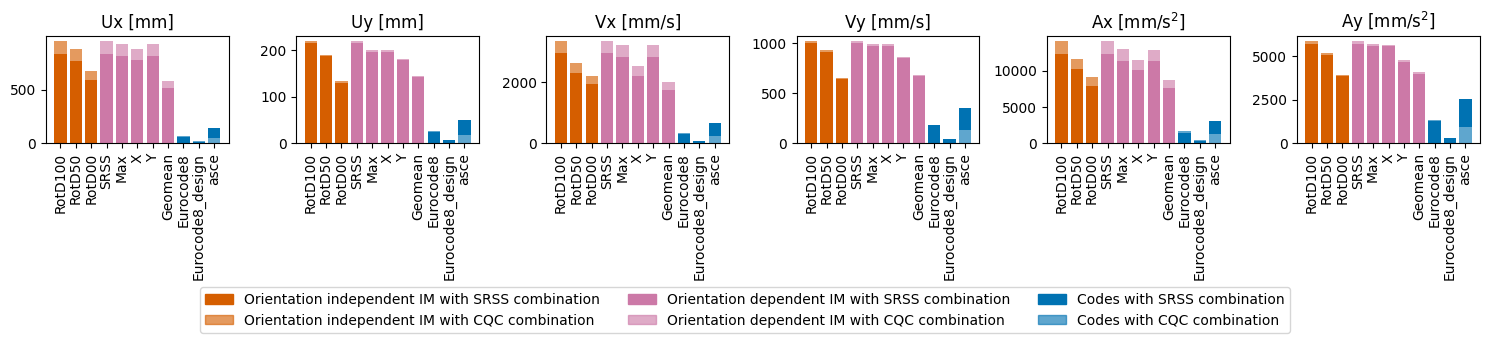

In [45]:
# Barplot of the ROOF displacements for each of the IMs
import matplotlib.patches as mpatches
colors_scientific=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
for earthquake in earthquakes_modal_analysis:
    fig, (axs) = plt.subplots(1, 6, figsize=(15,3))
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        y_values_bottom = []
        y_values_tha = []
        y_values_tha_bottom = []
        colors = []
        colors_tha = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            if earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im] > earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im]:
                y_values_tha.append(earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im]-earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_tha_bottom.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_bottom.append(0)
            else:
                y_values_tha.append(earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_tha_bottom.append(0)
                y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im]-earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_bottom.append(earthquakes_SRSS_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('#D55E00A0')
                colors_tha.append('#D55E00')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('#CC79A7A0')
                colors_tha.append('#CC79A7')
            else: #eurocode
                colors.append('#0072B2A0')
                colors_tha.append('#0072B2')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        
        axs[col].bar(xPos, y_values_tha, bottom=y_values_tha_bottom, color = colors_tha, label='')
        axs[col].bar(xPos, y_values, bottom=y_values_bottom, color = colors)
        plt.sca(axs[col])
        plt.xticks(xPos, xBars, rotation=90)
        axs[col].title.set_text(magnitude)
        if 'U' in magnitude:
            axs[col].title.set_text(magnitude+' [mm]')
        elif 'V' in magnitude:
            axs[col].title.set_text(magnitude+' [mm/s]')
        elif 'A' in magnitude:
            axs[col].title.set_text(magnitude+' [mm/s$^2$]')
        col += 1
        
    labels_legend = ['Orientation independent IM with SRSS combination', 'Orientation independent IM with CQC combination', 'Orientation dependent IM with SRSS combination', 'Orientation dependent IM with CQC combination', 'Codes with SRSS combination', 'Codes with CQC combination']
    colors_legend = ['#D55E00', '#D55E00A0', '#CC79A7', '#CC79A7A0', '#0072B2', '#0072B2A0']
    patch0 = mpatches.Patch(color=colors_legend[0], label=labels_legend[0])
    patch1 = mpatches.Patch(color=colors_legend[1], label=labels_legend[1])
    patch2 = mpatches.Patch(color=colors_legend[2], label=labels_legend[2])
    patch3 = mpatches.Patch(color=colors_legend[3], label=labels_legend[3])
    patch4 = mpatches.Patch(color=colors_legend[4], label=labels_legend[4])
    patch5 = mpatches.Patch(color=colors_legend[5], label=labels_legend[5])
    fig.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], ncols=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
        
    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig("./plots/CQC/srss_cqc_{eth}.svg".format(eth=earthquake))   
    plt.show()

In [46]:
# analysis definition
dt = 0.02 # is like the precision of the time series
def define_THA_analysis(time, gm1, gm2):
    """
    Configure the analysis type
    
    Parameters
    ------------
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
        
    Returns
    --------
    None
    """
    ops.timeSeries('Path', 1, '-dt', dt, '-values', *gm1*g, '-time', *time)
    ops.timeSeries('Path', 2, '-dt', dt, '-values', *gm2*g, '-time', *time)
    ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
    ops.pattern('UniformExcitation', 2, 2, '-accel', 2)
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('ProfileSPD')
    ops.algorithm('Linear', False, False, True)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')    

In [47]:
# Solve system
def solve_system(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes):
    """
    Solve the opensees system
    
    Parameters
    ------------
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with 'displacement', 'velocity' and 'acceleration' keys
    array
        array of natural periods of the structure (T [sec])
    """

    ops.wipe()
    
    # Model Definition
    periods, eigenvecs = model_definition(damping, studyNodes, nmodes)
        
    # Analysis Definition
    define_THA_analysis(time, gm1, gm2)

    node_outputs = {}
    for i in range(len(studyNodes)):
        node_outputs[studyNodes[i]] = {
            'X': {
                'displacement':[],
                'velocity':[], 
                'acceleration':[]
            },
            'Y': {
                'displacement':[],
                'velocity':[], 
                'acceleration':[]
            }
        }
    
    # Solve system
    analysis_time = time[-1]
    while ops.getTime() < analysis_time:
        ops.analyze(1, analysis_dt)
        for i in range(len(studyNodes)):
            node_outputs[studyNodes[i]]['X']['displacement'].append(ops.nodeDisp(studyNodes[i], 1))
            node_outputs[studyNodes[i]]['X']['velocity'].append(ops.nodeVel(studyNodes[i], 1))
            node_outputs[studyNodes[i]]['X']['acceleration'].append(ops.nodeAccel(studyNodes[i], 1))
            
            node_outputs[studyNodes[i]]['Y']['displacement'].append(ops.nodeDisp(studyNodes[i], 2))
            node_outputs[studyNodes[i]]['Y']['velocity'].append(ops.nodeVel(studyNodes[i], 2))
            node_outputs[studyNodes[i]]['Y']['acceleration'].append(ops.nodeAccel(studyNodes[i], 2)) 
        
    return node_outputs, periods

In [48]:
def get_Max(time, gm1, gm2, analysis_dt, damping, nmodes, studyNodes, theta):
    """
    Obtain ROTD
    
    Parameters
    ------------
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
    theta : float
        angle
        
    Returns
    --------
    dictionary
        dictionary with max 'X' and 'Y'
    array
        array of natural periods of the structure (T [sec])
    """

    numpyfunction = np.max
            
    outputs_x = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    
    outputs_y = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_theta_dir = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    outputs_xy = {
        'displacement':0,
        'velocity':0, 
        'acceleration':0
    }
    ROTD = {
        'X': outputs_x,
        'Y': outputs_y,
        'theta_dir': outputs_theta_dir,
        'X+Y' : outputs_xy
    }

    a_ROT = create_aROT(gm1, gm2, theta)
    a_ROT_x = a_ROT*math.cos(np.deg2rad(theta))
    a_ROT_y = a_ROT*math.sin(np.deg2rad(theta))
    results, periods = solve_system(time, a_ROT_x, a_ROT_y, analysis_dt, damping, nmodes, studyNodes)


    max_outputs = {}
    for i in range(len(studyNodes)):
        max_outputs[studyNodes[i]] = {
            'X': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            },
            'Y': {
                'displacement':0.0,
                'velocity':0.0, 
                'acceleration':0.0
            }
        }

    for node in results:
        max_outputs[node]['X']['displacement'] = np.max(np.abs(np.array(results[node]['X']['displacement'])))
        max_outputs[node]['X']['velocity'] = np.max(np.abs(np.array(results[node]['X']['velocity'])))
        max_outputs[node]['X']['acceleration'] = np.max(np.abs(np.array(results[node]['X']['acceleration'])))
        
        max_outputs[node]['Y']['displacement'] = np.max(np.abs(np.array(results[node]['Y']['displacement'])))
        max_outputs[node]['Y']['velocity'] = np.max(np.abs(np.array(results[node]['Y']['velocity'])))
        max_outputs[node]['Y']['acceleration'] = np.max(np.abs(np.array(results[node]['Y']['acceleration'])))
    
    return results, max_outputs, periods


In [49]:
studyNodes = nodes_left_side

In [50]:
theta_list_analysis = np.linspace(1, 180, 45, endpoint=True)

In [51]:
import pickle
plot_data_roof_node = {}
for earthquake in earthquakes_data:
    plot_data_roof_node[earthquake] = {
        'displacement': {
            'X': [],
            'Y': []
        },
        'velocity': {
            'X': [],
            'Y': []
        },
        'acceleration': {
            'X': [],
            'Y': []
        }
    }
for earthquake in tqdm(earthquakes_data):
    with open('earthquakes_tha_{eth}.txt'.format(eth=earthquake), 'rb') as handle:
        earthquakes_tha = pickle.loads(handle.read())
    for angle in earthquakes_tha:
        plot_data_roof_node[earthquake]['displacement']['X'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['X']['displacement'])
        plot_data_roof_node[earthquake]['displacement']['Y'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['Y']['displacement'])

        plot_data_roof_node[earthquake]['velocity']['X'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['X']['velocity'])
        plot_data_roof_node[earthquake]['velocity']['Y'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['Y']['velocity'])

        plot_data_roof_node[earthquake]['acceleration']['X'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['X']['acceleration'])
        plot_data_roof_node[earthquake]['acceleration']['Y'].append(earthquakes_tha[angle][studyNodes[len(studyNodes)-1]]['max']['Y']['acceleration'])

100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.00s/it]


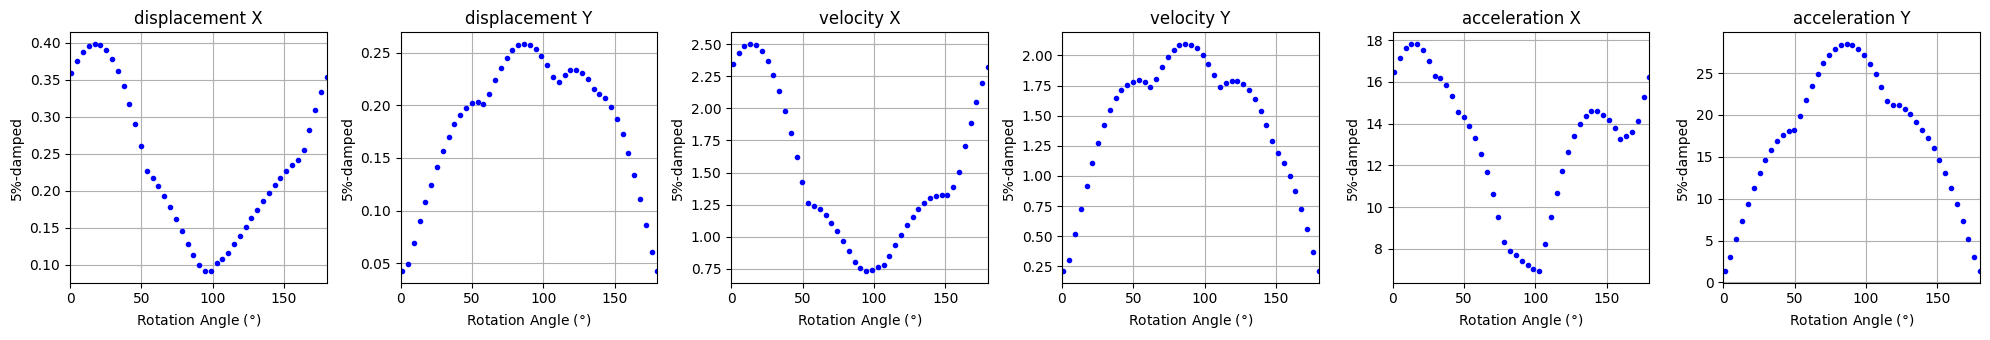

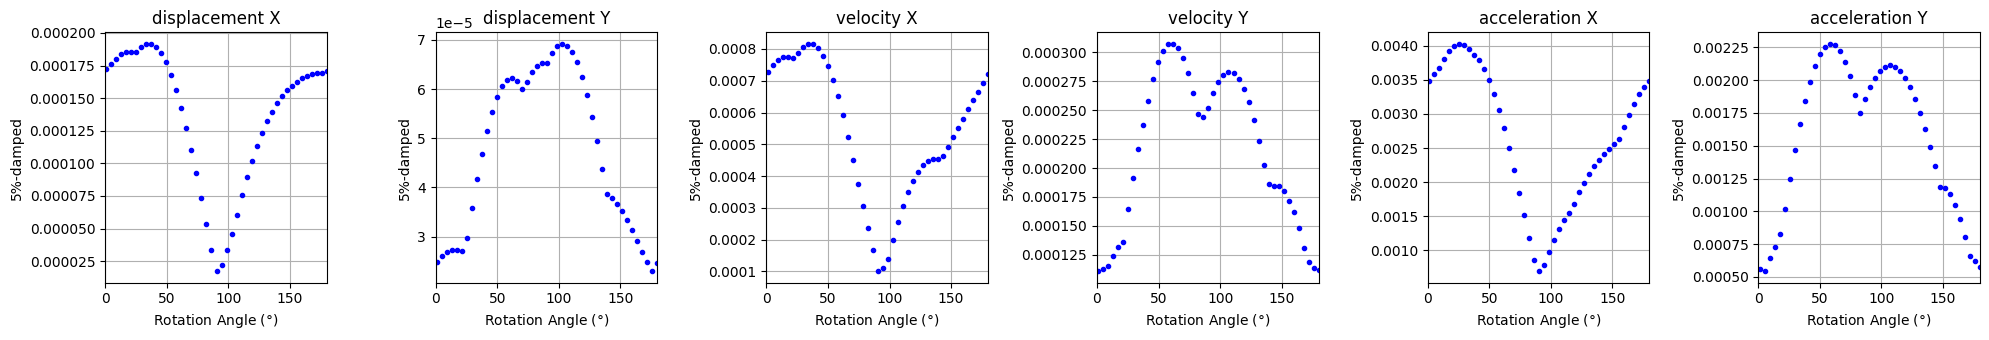

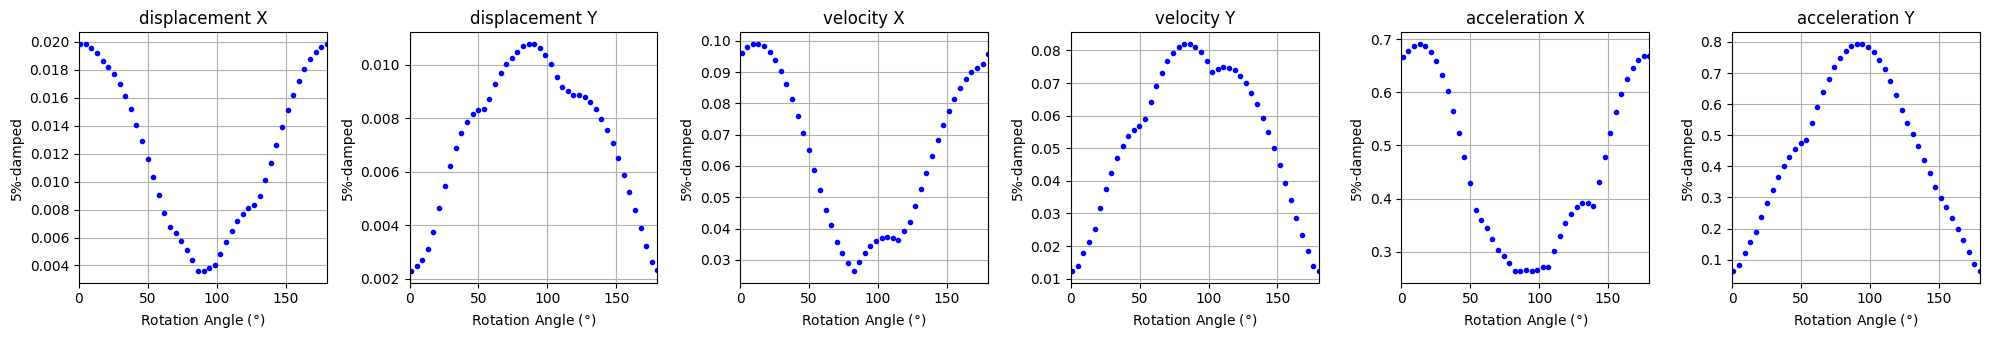

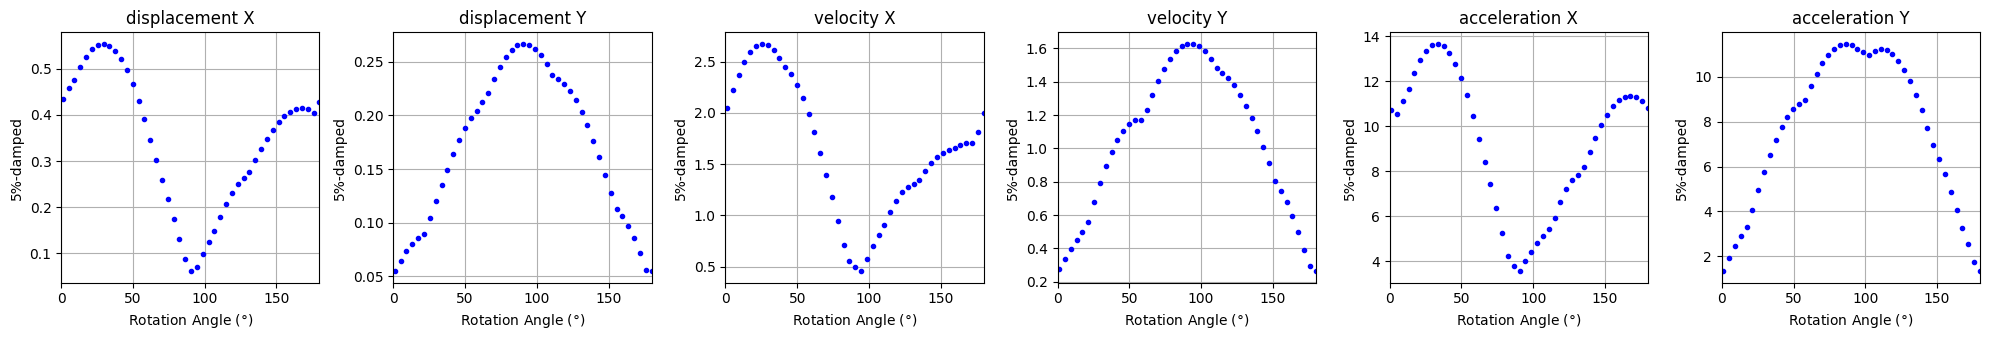

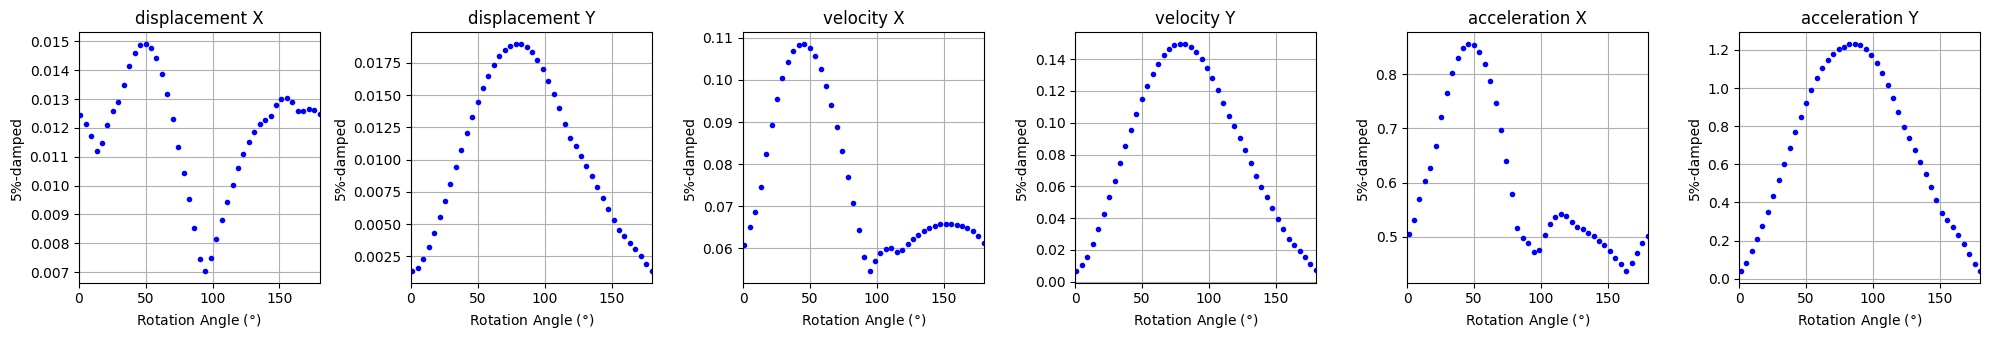

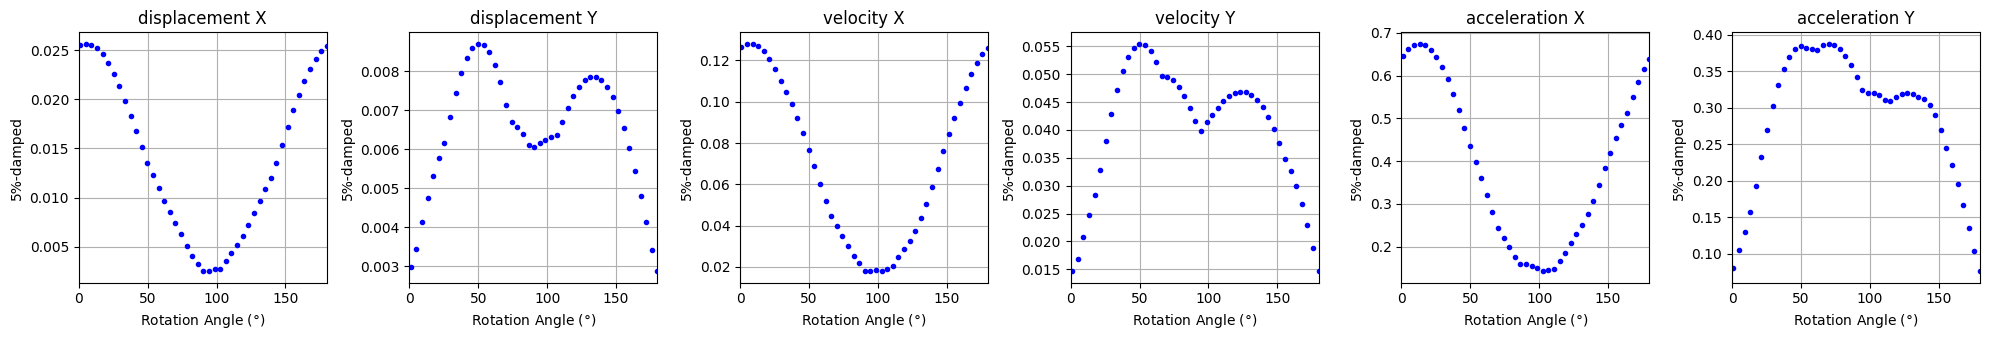

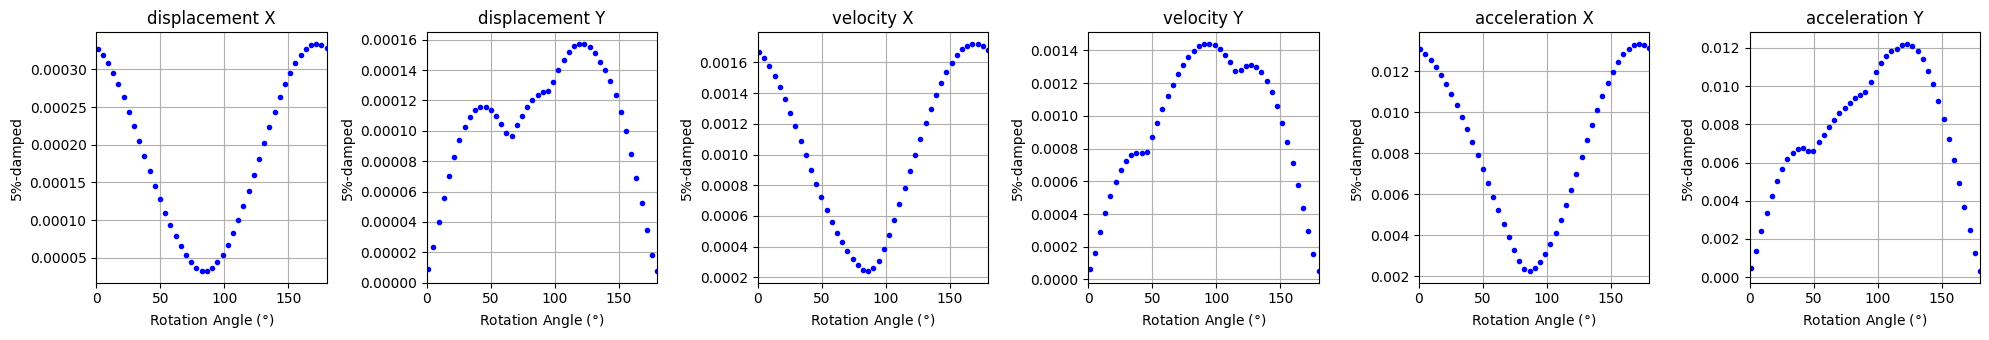

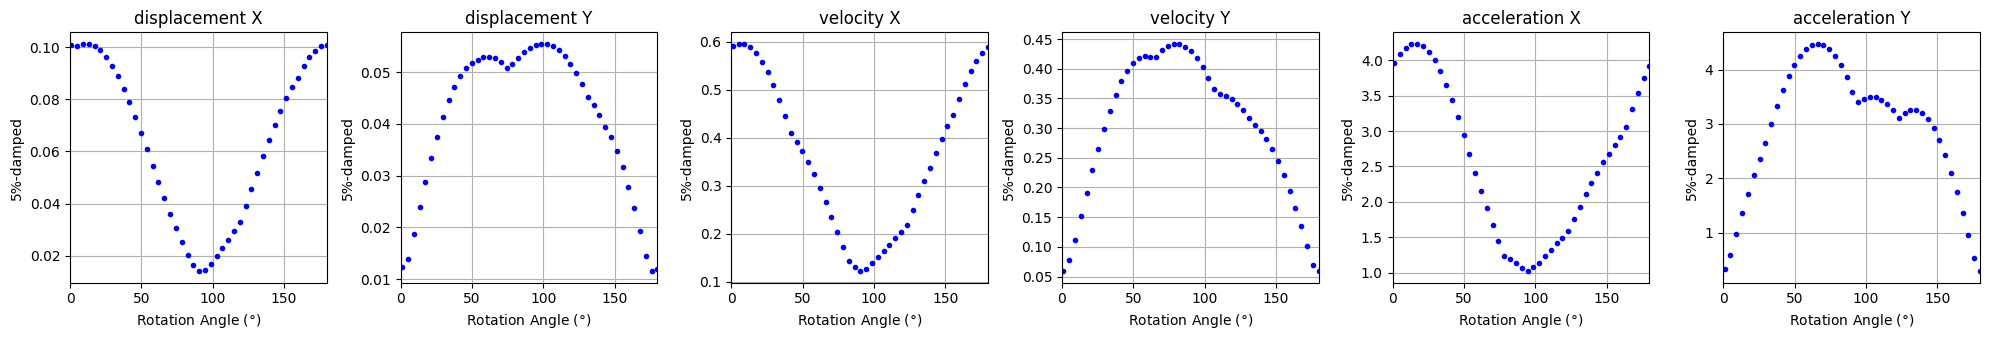

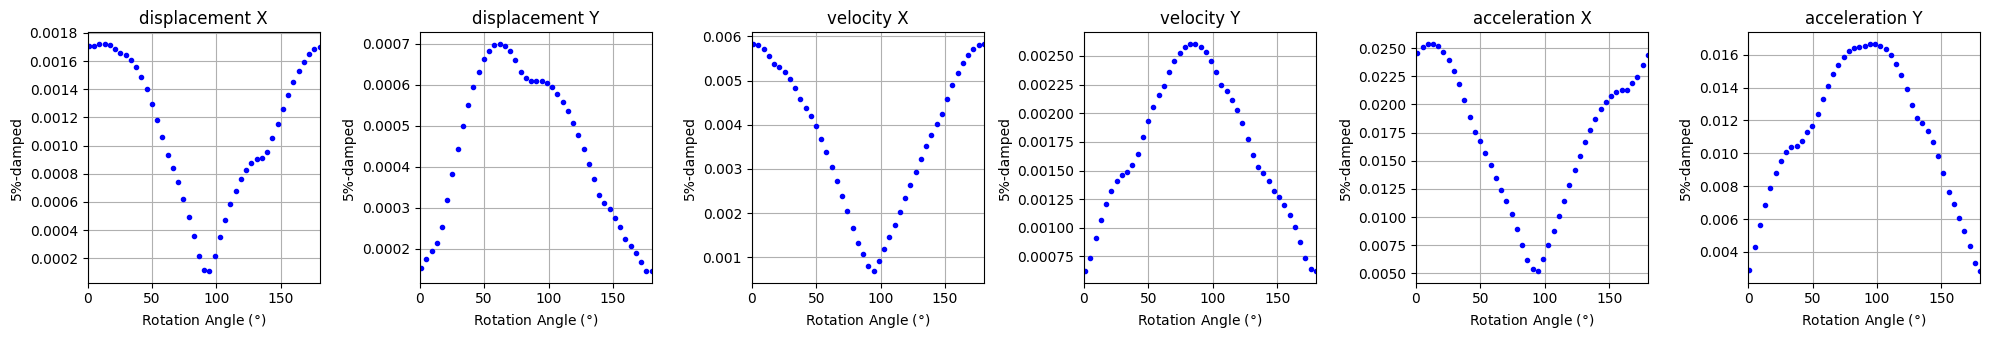

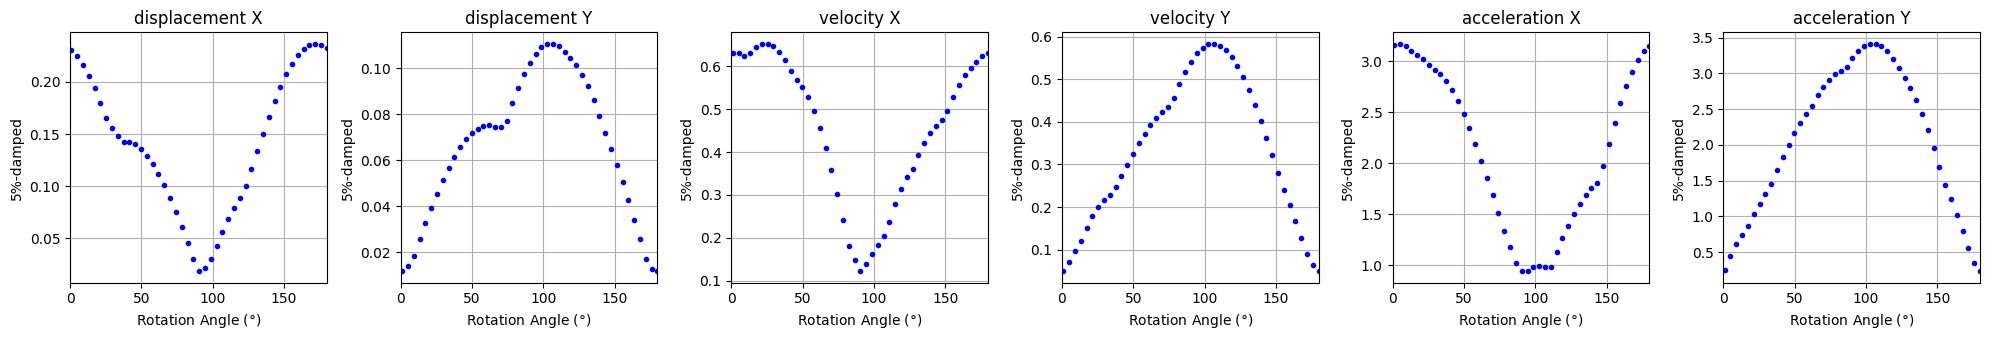

In [52]:
for earthquake in plot_data_roof_node:
    fig, (axs) = plt.subplots(1, 6, figsize=(20,3.5))
    col = 0
    for key in plot_data_roof_node[earthquake]:
        for dir in plot_data_roof_node[earthquake][key]:
            axs[col].plot(theta_list_analysis, plot_data_roof_node[earthquake][key][dir],".",color='blue')
            axs[col].set(ylabel='5%-damped', xlabel='Rotation Angle ($\degree$)')
            axs[col].title.set_text('{key} {dir}'.format(key=key, dir=dir))
            axs[col].grid()
            #axs[row,col].legend()
            axs[col].set_xlim(left=0)
            axs[col].set_xlim(right=max(theta_list_analysis))
            col += 1 
    
    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig("./plots/RoofNodeVsAngle/roof_node_{eth}.svg".format(eth=earthquake))    
    plt.show()

In [53]:
# Time Story Analysis Values to add to the bar plot
earthquakes_THA_roof_node = {}
for earthquake in earthquakes_data:
    earthquakes_THA_roof_node[earthquake] = {
        'Ux': 0.0,
        'Uy': 0.0,
        'Vx': 0.0,
        'Vy': 0.0,
        'Ax': 0.0,
        'Ay': 0.0 
    }

In [54]:
for earthquake in earthquakes_THA_roof_node:
    earthquakes_THA_roof_node[earthquake]['Ux'] = np.max(np.array(plot_data_roof_node[earthquake]['displacement']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Uy'] = np.max(np.array(plot_data_roof_node[earthquake]['displacement']['Y']))*1e3
    earthquakes_THA_roof_node[earthquake]['Vx'] = np.max(np.array(plot_data_roof_node[earthquake]['velocity']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Vy'] = np.max(np.array(plot_data_roof_node[earthquake]['velocity']['Y']))*1e3
    earthquakes_THA_roof_node[earthquake]['Ax'] = np.max(np.array(plot_data_roof_node[earthquake]['acceleration']['X']))*1e3
    earthquakes_THA_roof_node[earthquake]['Ay'] = np.max(np.array(plot_data_roof_node[earthquake]['acceleration']['Y']))*1e3

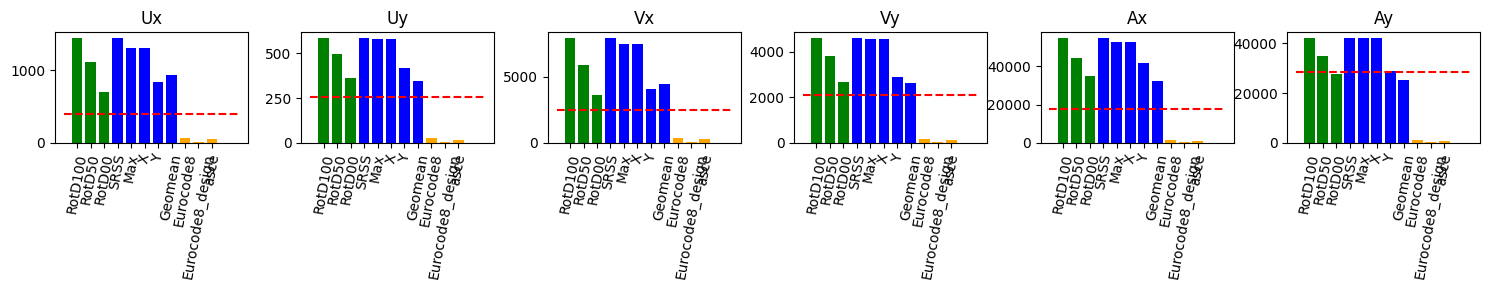

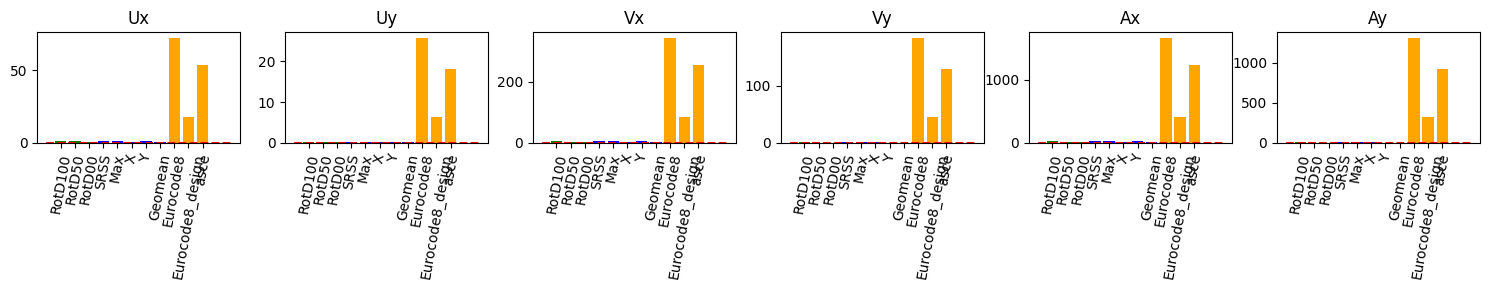

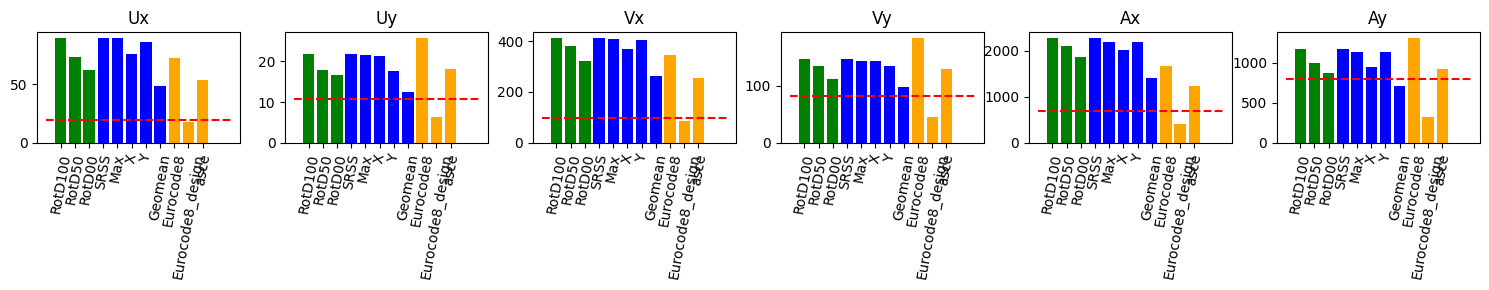

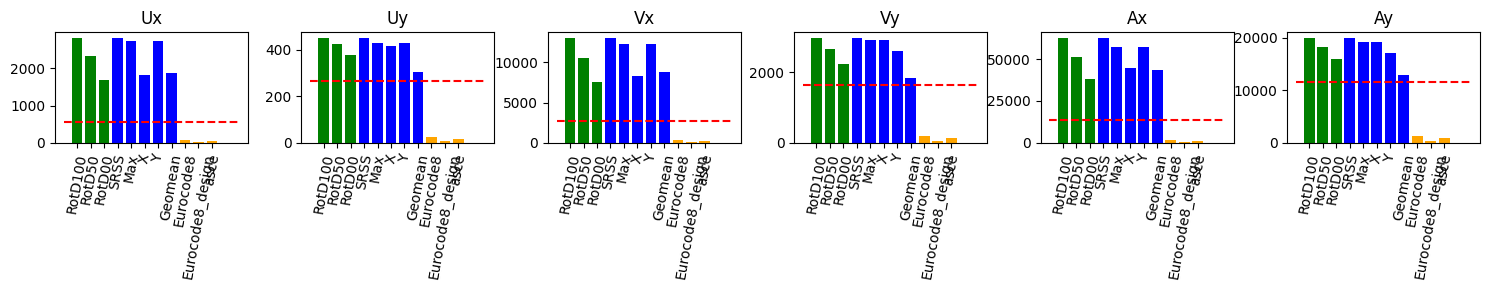

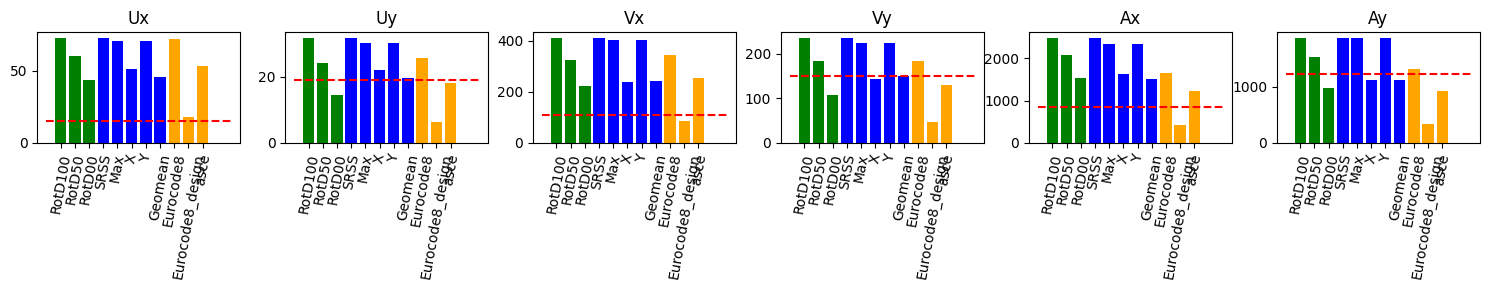

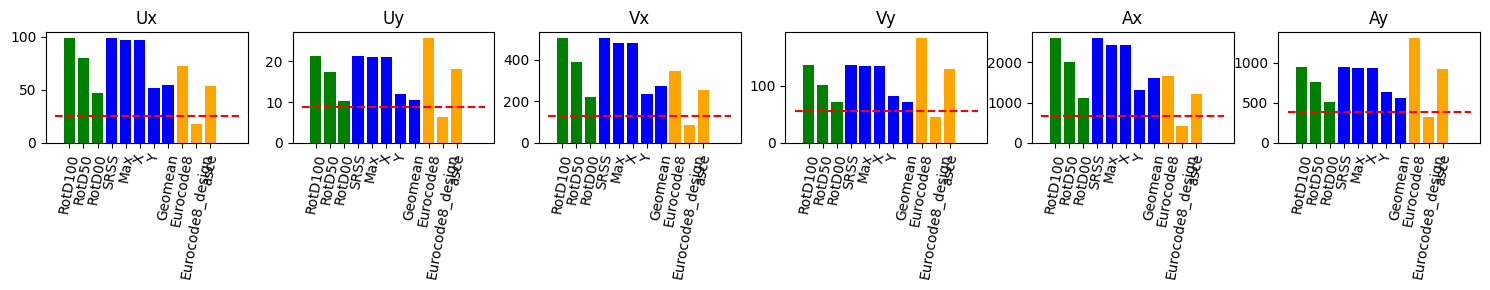

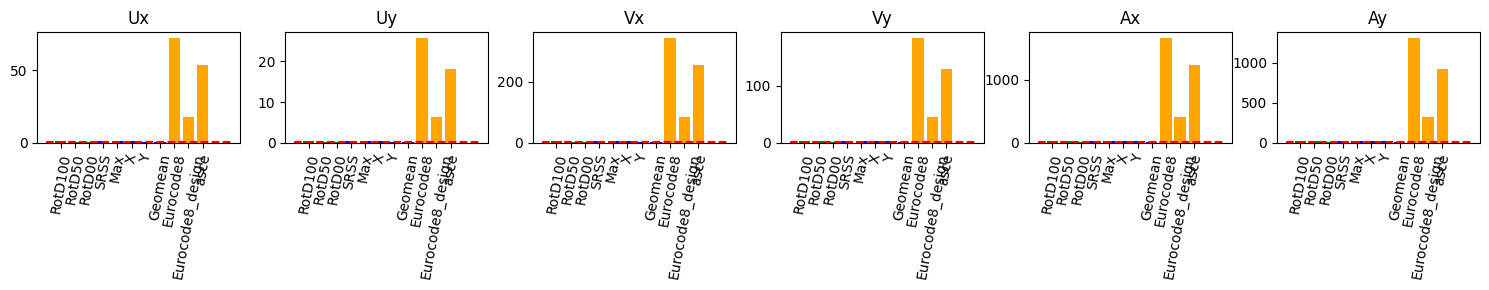

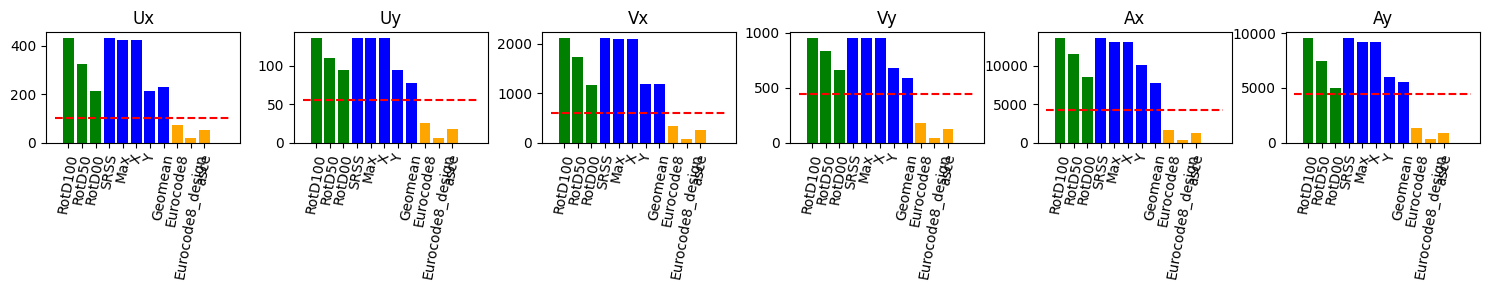

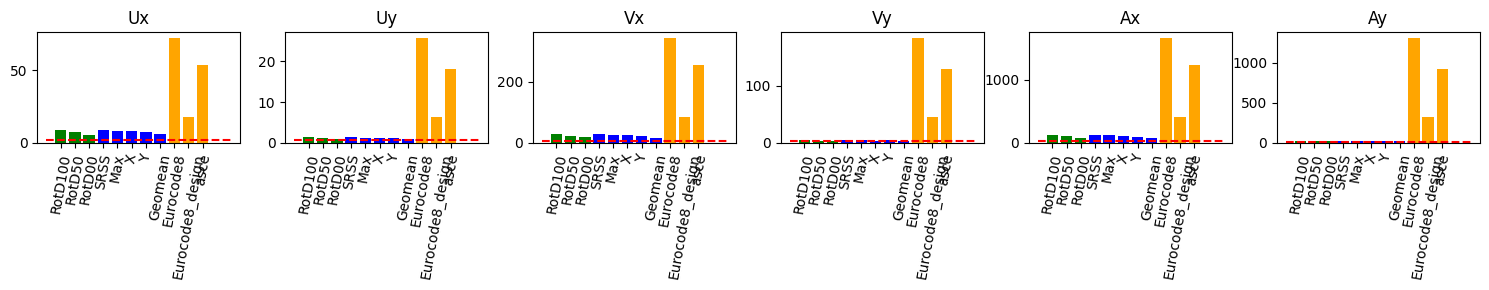

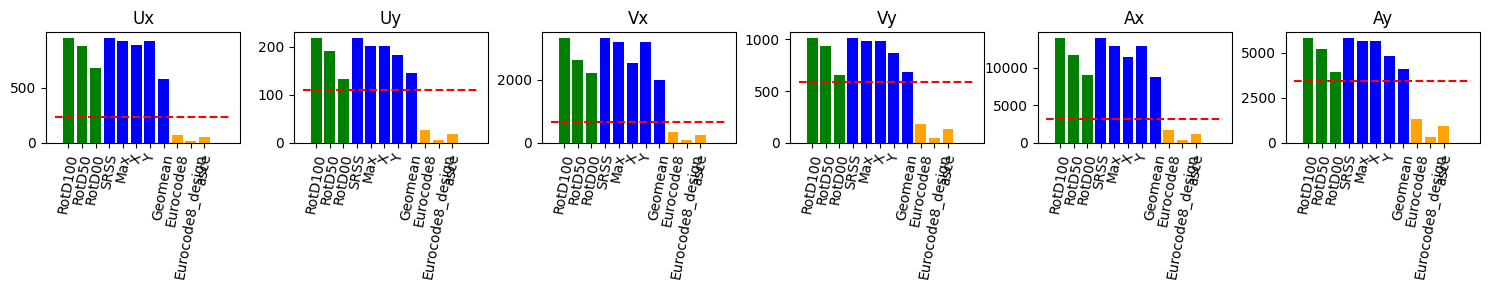

In [55]:
# Barplot of the ROOF displacements for each of the IMs (CQC METHOD)
for earthquake in earthquakes_modal_analysis:
    fig, (axs) = plt.subplots(1, 6, figsize=(15,3))
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        colors = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('green')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('blue')
            else: #eurocode
                colors.append('orange')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        axs[col].bar(xPos, y_values, color = colors)
        plt.sca(axs[col])
        plt.xticks(xPos, xBars, rotation=80)
        axs[col].title.set_text(magnitude)
        axs[col].plot([-1, len(xPos)+1], [earthquakes_THA_roof_node[earthquake][magnitude], earthquakes_THA_roof_node[earthquake][magnitude]], "r--")
        
        col += 1

    fig.tight_layout(h_pad=2.0, w_pad=0.0)
    plt.savefig("./plots/Comparison/comparison_{eth}.svg".format(eth=earthquake)) 
    plt.show()

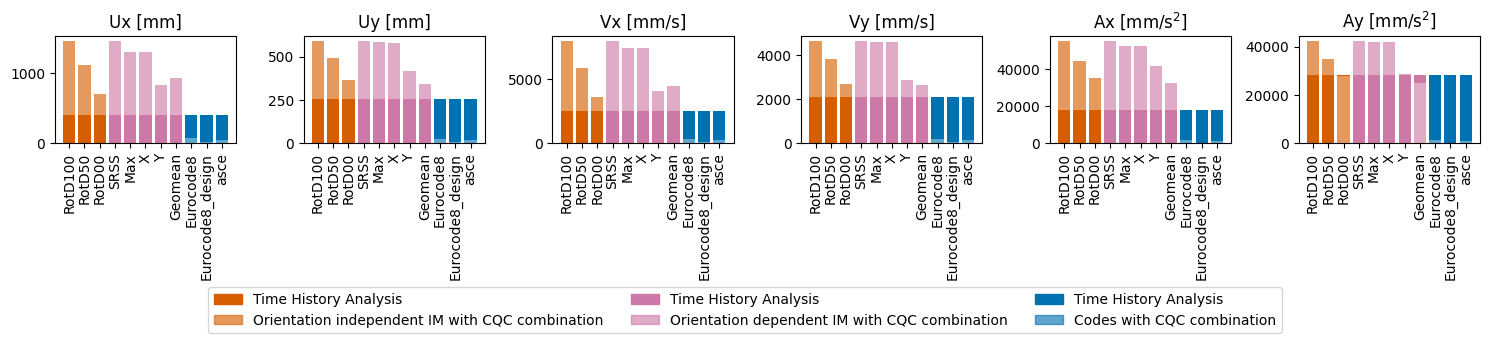

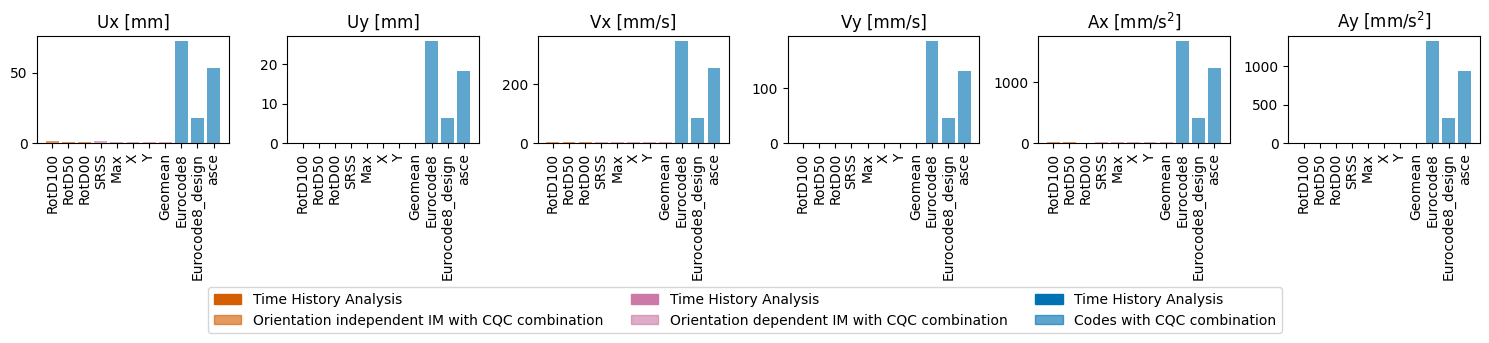

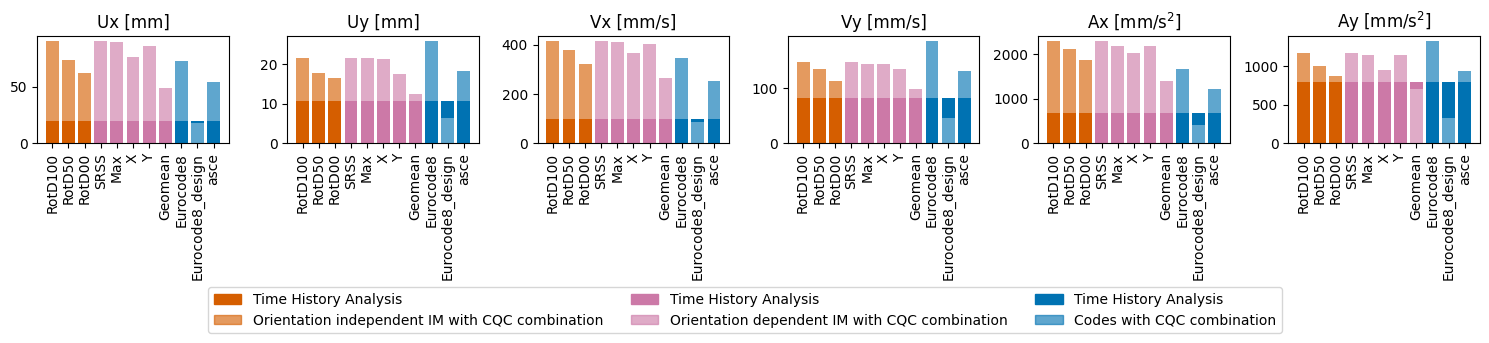

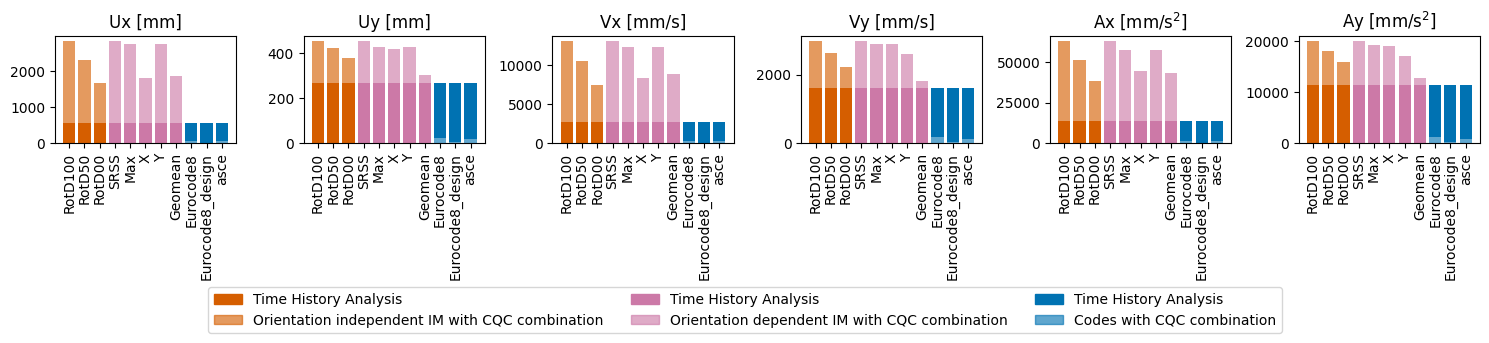

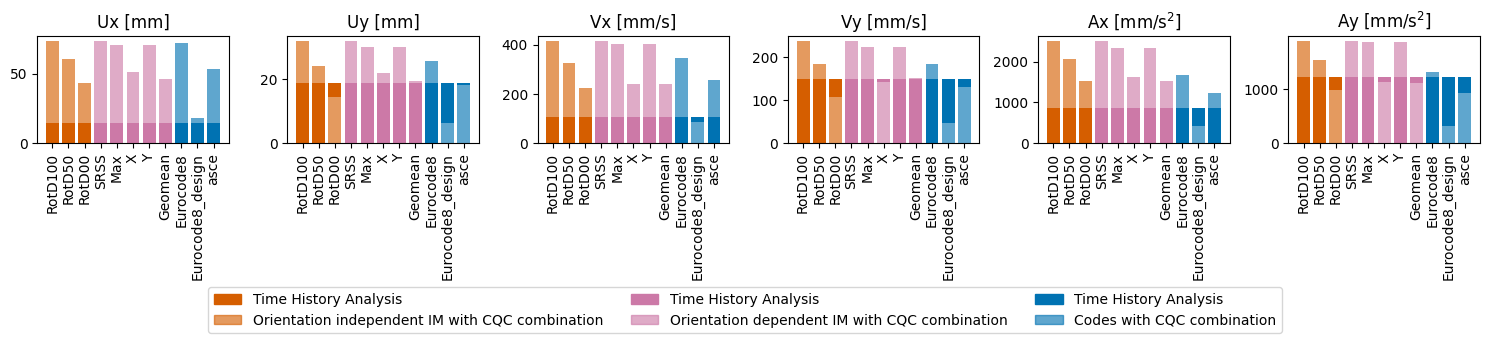

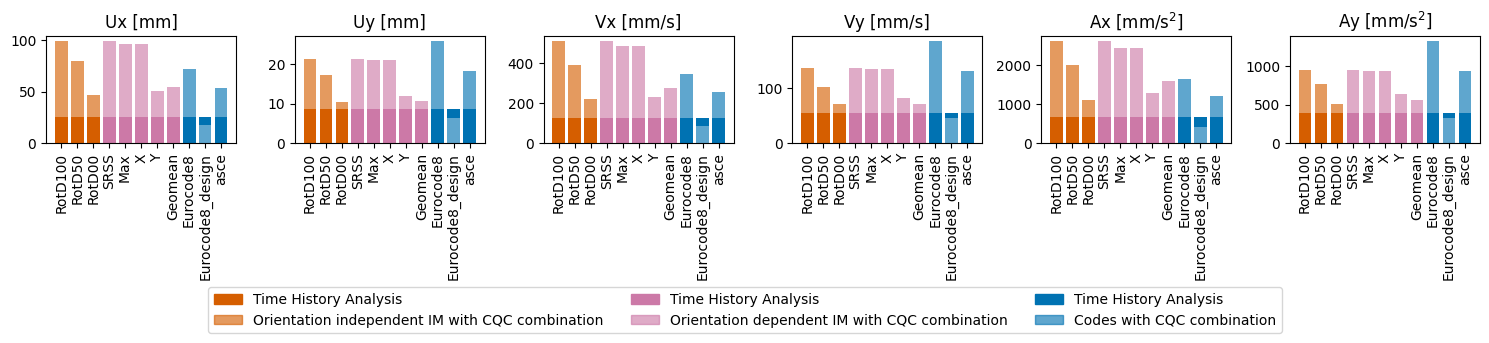

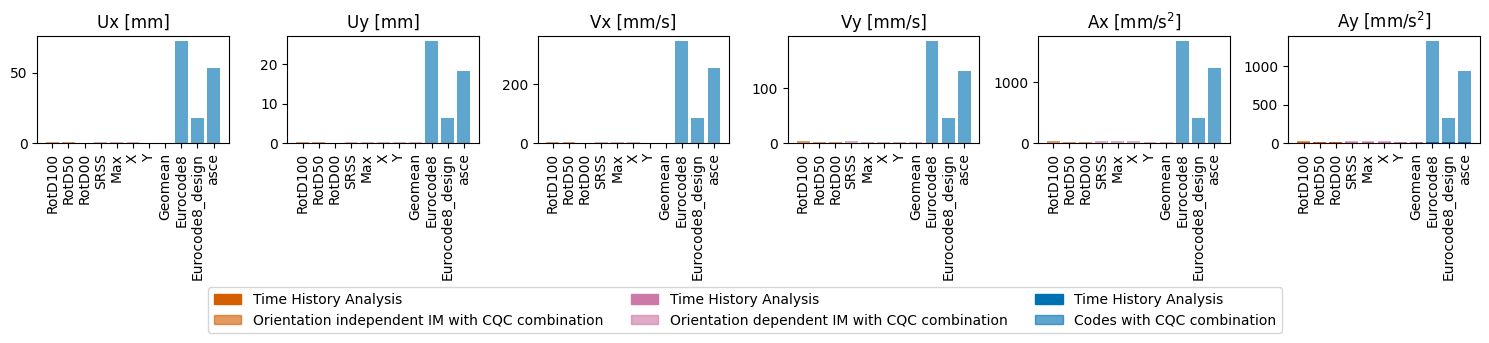

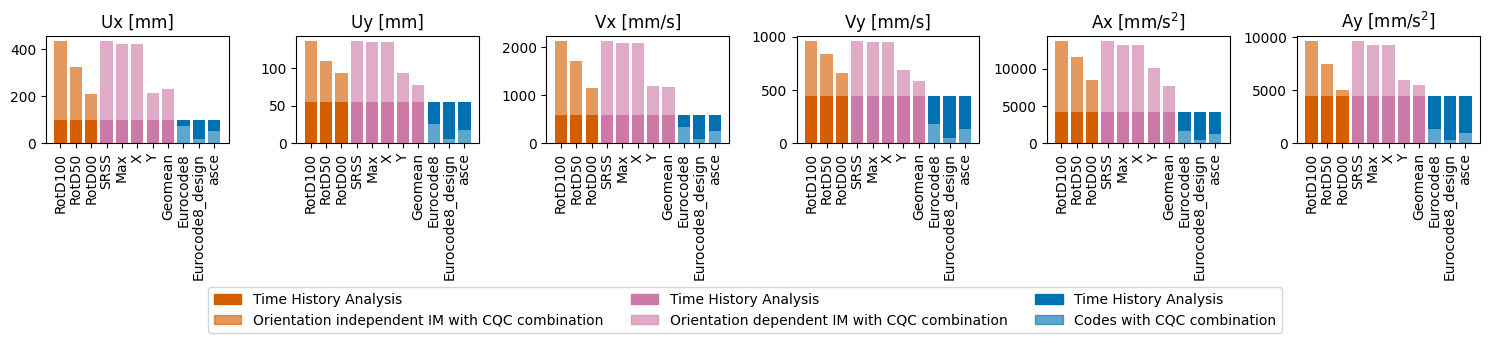

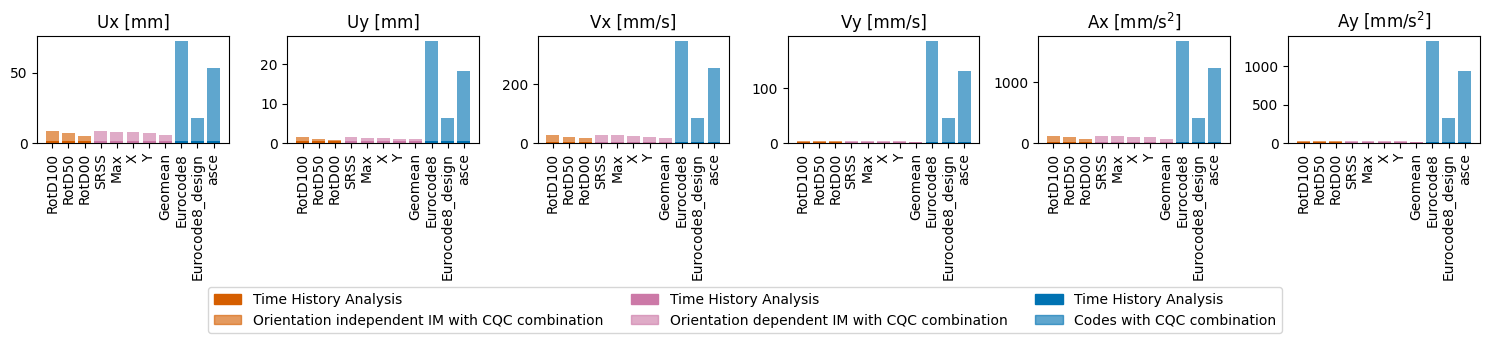

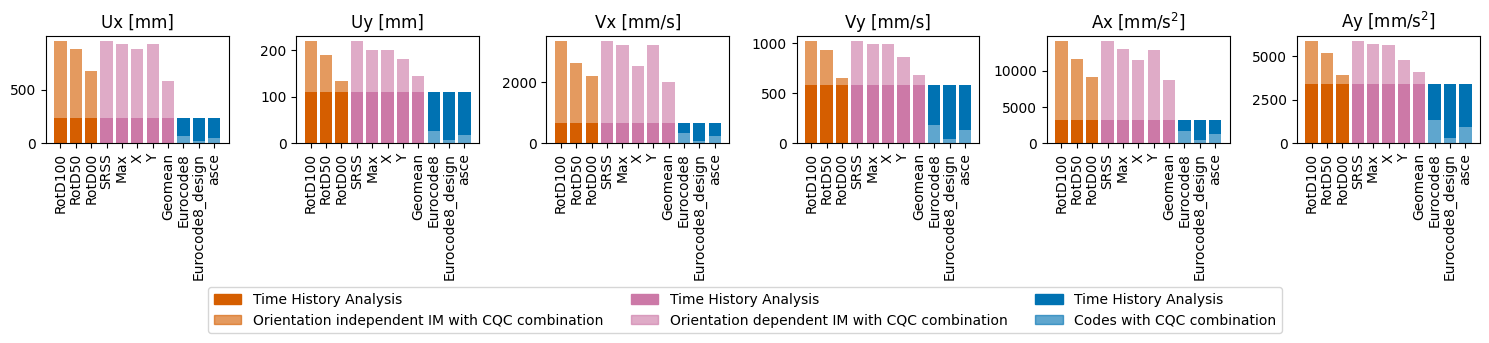

In [56]:
# Barplot of the ROOF displacements for each of the IMs
import matplotlib.patches as mpatches
colors_scientific=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
for earthquake in earthquakes_modal_analysis:
    fig, (axs) = plt.subplots(1, 6, figsize=(15,3))
    col = 0
    for magnitude in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]]:
        ## ---------    Calculate xBar names and y coordinates ------------------------
        xPos = []
        xPosInit = 0
        xBars = []
        y_values = []
        y_values_bottom = []
        y_values_tha = []
        y_values_tha_bottom = []
        colors = []
        colors_tha = []
        for im in earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude]:
            xBars.append(im)
            xPos.append(xPosInit)
            if earthquakes_THA_roof_node[earthquake][magnitude] > earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im]:
                y_values_tha.append(earthquakes_THA_roof_node[earthquake][magnitude]-earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_tha_bottom.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im])
                y_values_bottom.append(0)
            else:
                y_values_tha.append(earthquakes_THA_roof_node[earthquake][magnitude])
                y_values_tha_bottom.append(0)
                y_values.append(earthquakes_CQC_combination[earthquake][nodes_left_side[len(nodes_left_side)-1]][magnitude][im]-earthquakes_THA_roof_node[earthquake][magnitude])
                y_values_bottom.append(earthquakes_THA_roof_node[earthquake][magnitude])
            if im == 'RotD100' or im == 'RotD50' or im == 'RotD00': #orientation-independent
                colors.append('#D55E00A0')
                colors_tha.append('#D55E00')
            elif im == 'SRSS' or im == 'Max' or im == 'X' or im == 'Y' or im == 'Geomean': #orientation-dependent
                colors.append('#CC79A7A0')
                colors_tha.append('#CC79A7')
            else: #eurocode
                colors.append('#0072B2A0')
                colors_tha.append('#0072B2')
            xPosInit += 1
        ## ---------    Draw plot -----------------------------------------------------
        
        axs[col].bar(xPos, y_values_tha, bottom=y_values_tha_bottom, color = colors_tha)
        axs[col].bar(xPos, y_values, bottom=y_values_bottom, color = colors)
        plt.sca(axs[col])
        plt.xticks(xPos, xBars, rotation=90)
        axs[col].title.set_text(magnitude)
        if 'U' in magnitude:
            axs[col].title.set_text(magnitude+' [mm]')
        elif 'V' in magnitude:
            axs[col].title.set_text(magnitude+' [mm/s]')
        elif 'A' in magnitude:
            axs[col].title.set_text(magnitude+' [mm/s$^2$]')
        
        col += 1

    labels_legend = ['Time History Analysis', 'Orientation independent IM with CQC combination', 'Time History Analysis', 'Orientation dependent IM with CQC combination', 'Time History Analysis', 'Codes with CQC combination']
    colors_legend = ['#D55E00', '#D55E00A0', '#CC79A7', '#CC79A7A0', '#0072B2', '#0072B2A0']
    patch0 = mpatches.Patch(color=colors_legend[0], label=labels_legend[0])
    patch1 = mpatches.Patch(color=colors_legend[1], label=labels_legend[1])
    patch2 = mpatches.Patch(color=colors_legend[2], label=labels_legend[2])
    patch3 = mpatches.Patch(color=colors_legend[3], label=labels_legend[3])
    patch4 = mpatches.Patch(color=colors_legend[4], label=labels_legend[4])
    patch5 = mpatches.Patch(color=colors_legend[5], label=labels_legend[5])
    fig.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], ncols=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
        
    fig.tight_layout(h_pad=2.0, w_pad=1.0)
    plt.savefig("./plots/Comparison/stack_bar_{eth}.svg".format(eth=earthquake))   
    plt.show()

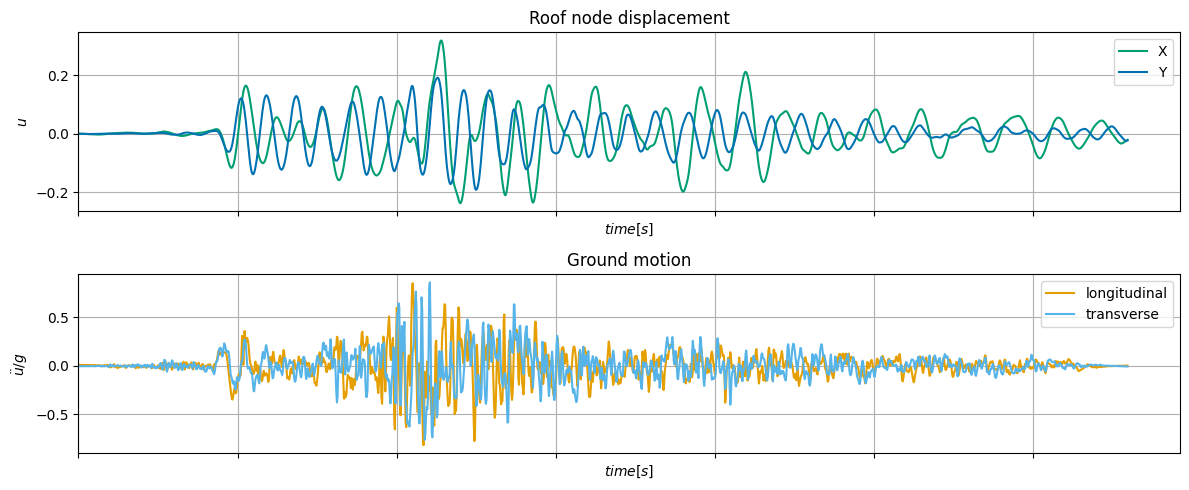

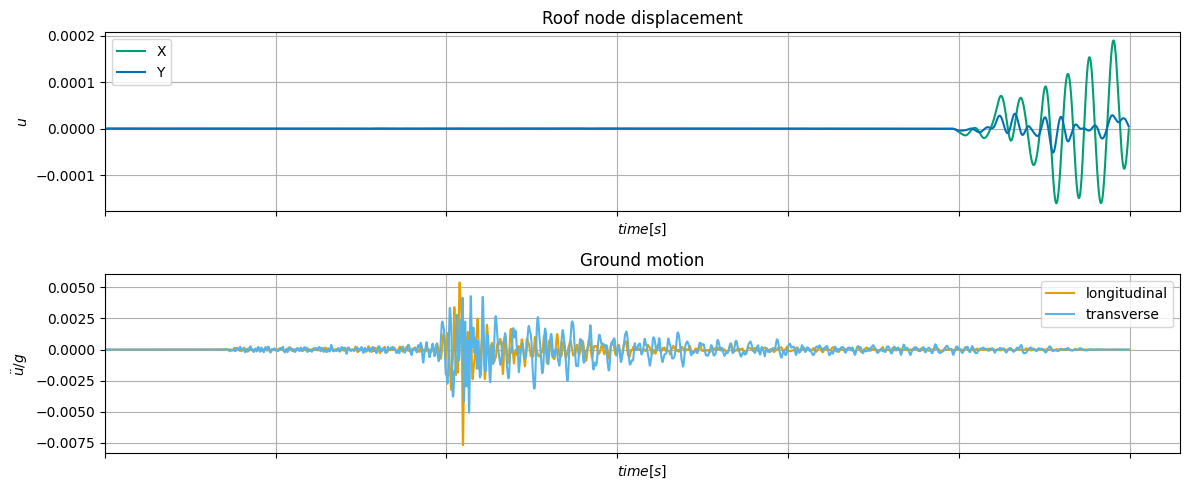

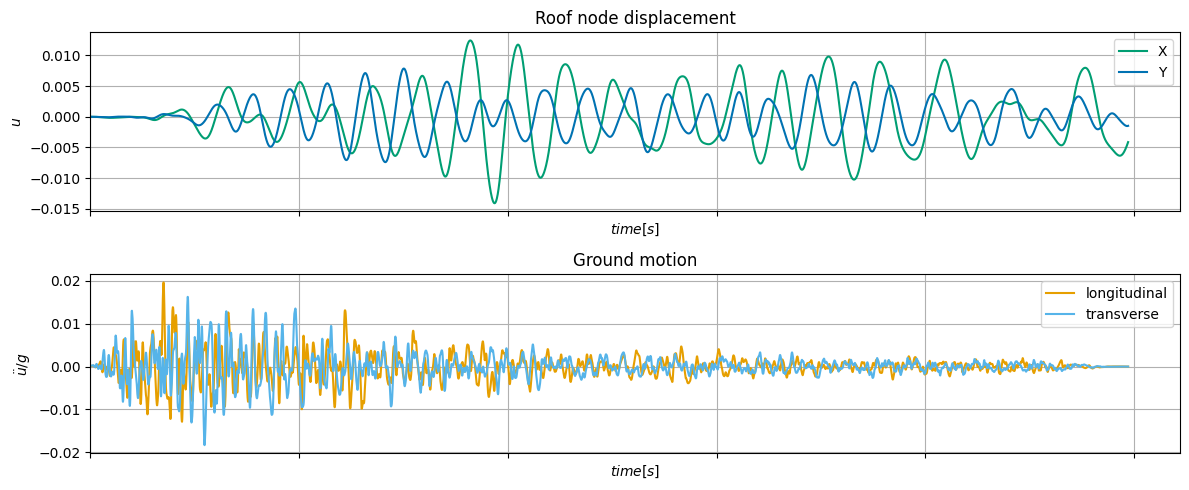

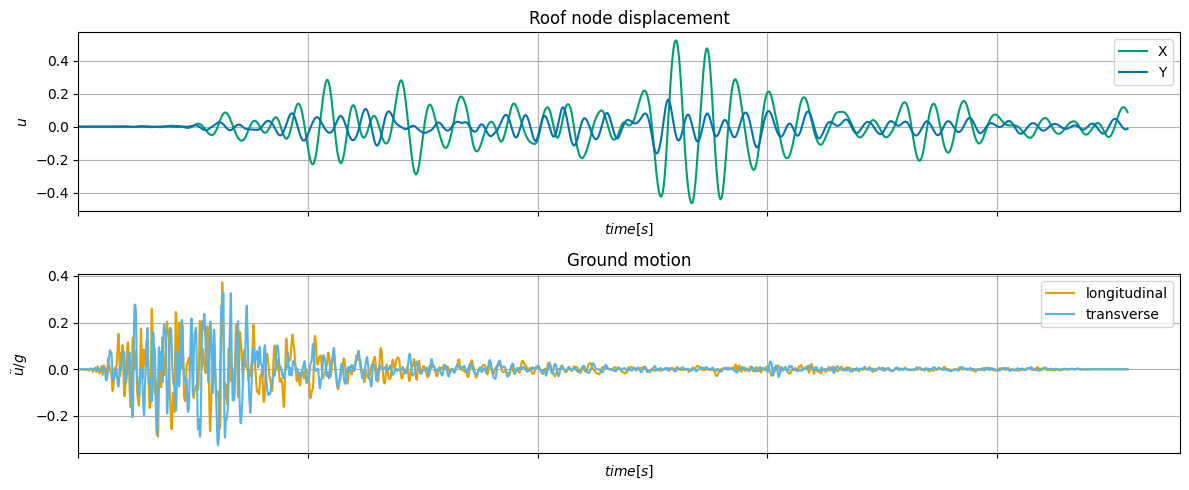

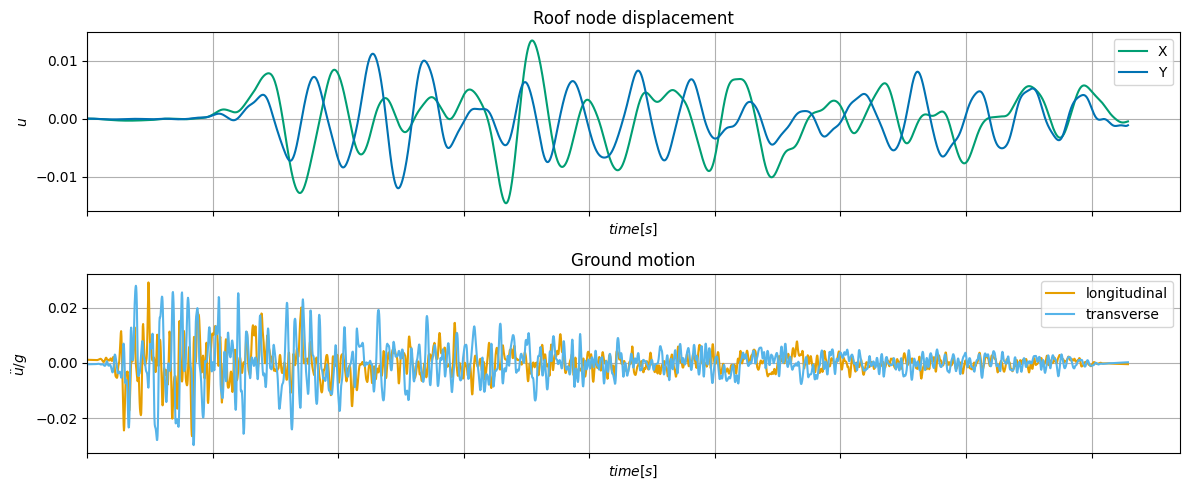

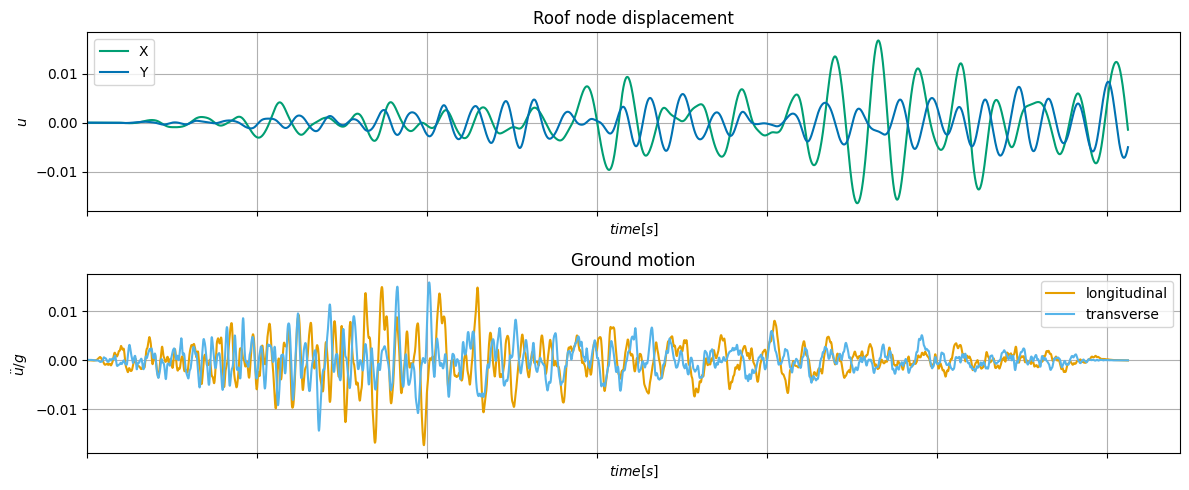

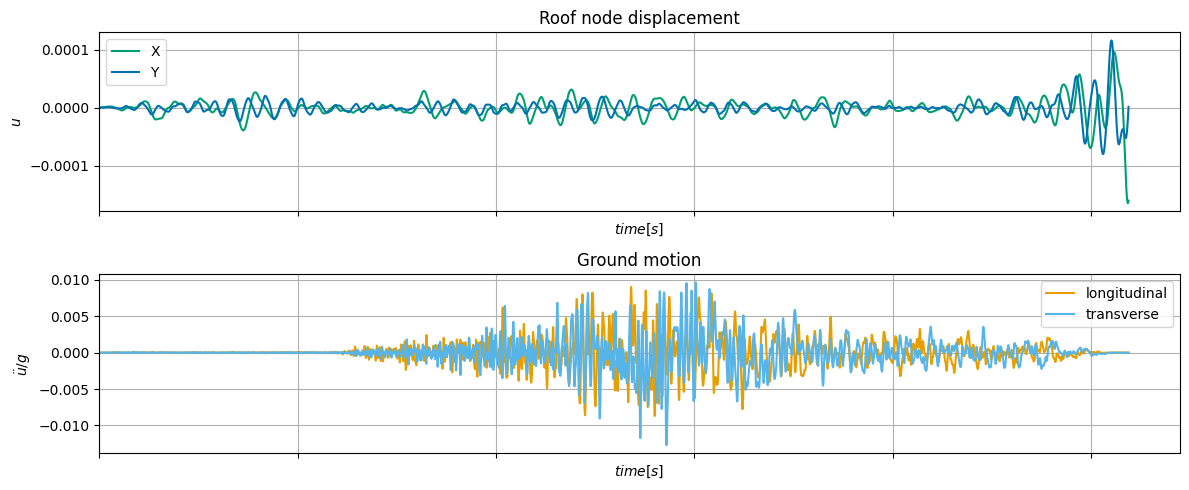

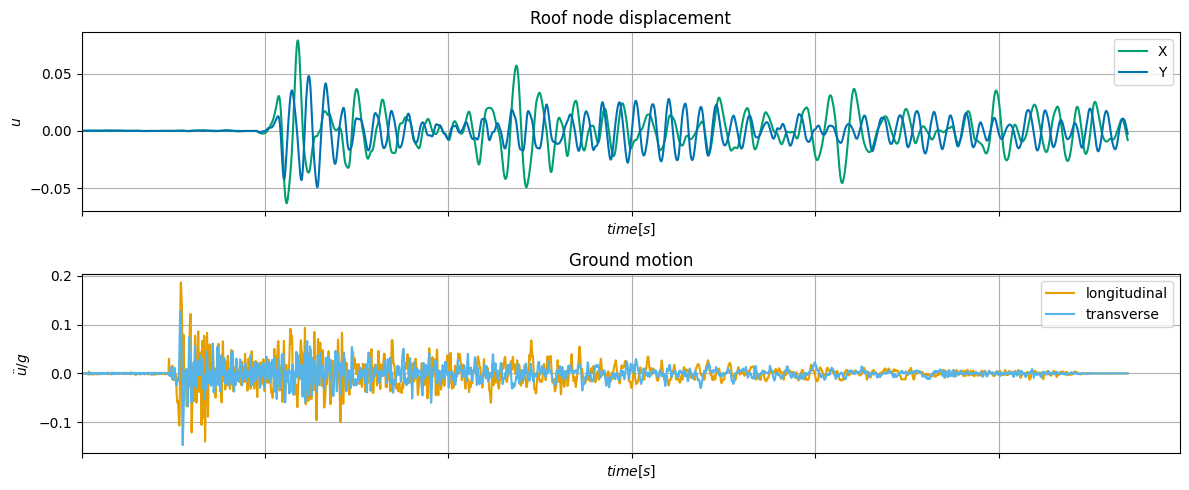

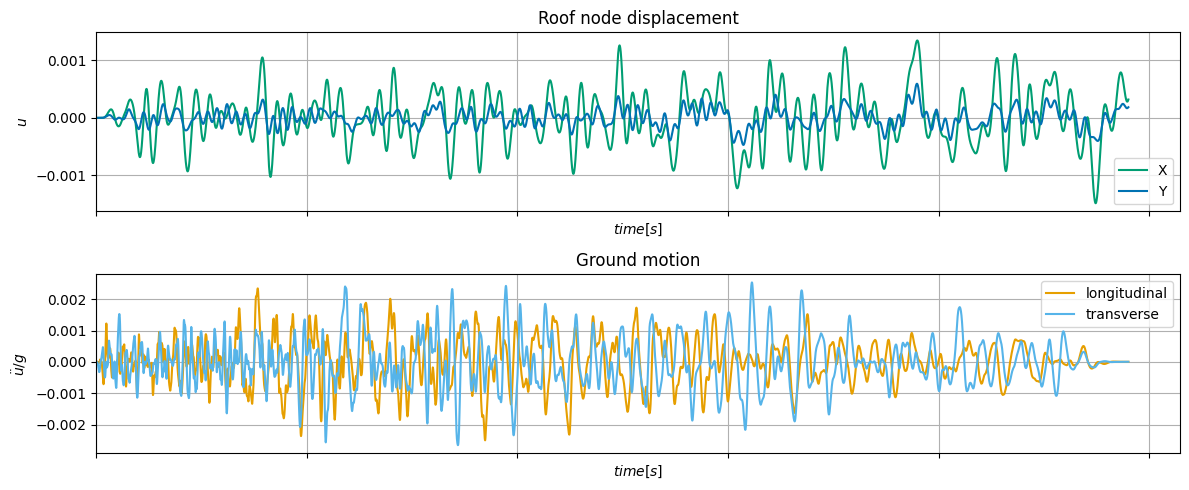

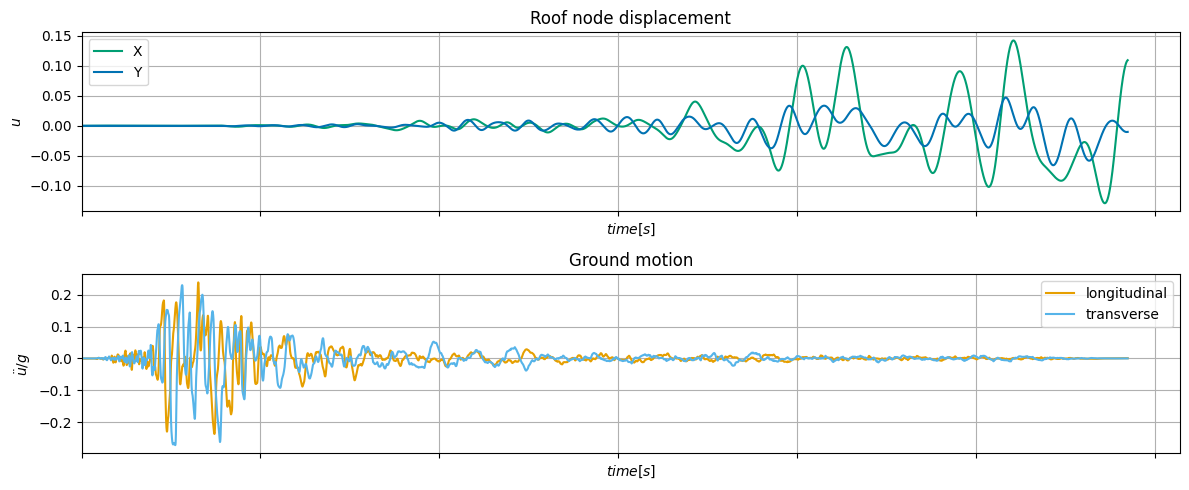

In [57]:
angle = theta_list_analysis[10]

for ethqke_name in earthquakes_data:
    with open('earthquakes_tha_{eth}.txt'.format(eth=ethqke_name), 'rb') as handle:
        earthquakes_tha = pickle.loads(handle.read())

    maxLen = len(earthquakes_data[ethqke_name]['GMD_longitudinal']['time']) - 1
    fig = plt.figure(figsize=(12,5)) #select the visualization size of the plot
    ax1=plt.subplot(211)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:maxLen], earthquakes_tha[angle][nodes_left_side[len(nodes_left_side)-1]]['results'][nodes_left_side[len(nodes_left_side)-1]]['X']['displacement'][:maxLen], color='#009E73', label='X')
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:maxLen], earthquakes_tha[angle][nodes_left_side[len(nodes_left_side)-1]]['results'][nodes_left_side[len(nodes_left_side)-1]]['Y']['displacement'][:maxLen], color='#0072B2', label='Y')
    plt.xlabel('$time [s]$')
    plt.ylabel('$u$')
    plt.title('Roof node displacement')
    plt.grid()
    plt.xlim(left=0)
    plt.legend()

    #["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
    
    ax2=plt.subplot(212)
    plt.setp(ax2.get_xticklabels(),visible=False)
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:maxLen], earthquakes_data[ethqke_name]['GMD_longitudinal']['gmdata'][:maxLen], color='#E69F00', label='longitudinal')
    plt.plot(earthquakes_data[ethqke_name]['GMD_longitudinal']['time'][:maxLen], earthquakes_data[ethqke_name]['GMD_transverse']['gmdata'][:maxLen], color='#56B4E9', label='transverse')
    plt.xlabel('$time [s]$')
    plt.ylabel('$\ddot{u}/g$')
    plt.title('Ground motion')
    plt.grid()
    plt.xlim(left=0)
    plt.legend()

    fig.tight_layout(h_pad=1.0, w_pad=0.0)
    plt.savefig("./plots/DisplacementVsTime/roof_disp_{eth}.svg".format(eth=ethqke_name))
    plt.show()

In [58]:
ethqke_name='Tabas'
with open('earthquakes_tha_{eth}.txt'.format(eth=ethqke_name), 'rb') as handle:
    earthquakes_tha = pickle.loads(handle.read())
earthquakes_tha[angle][nodes_left_side[len(nodes_left_side)-1]]['max']['X']['displacement']

0.3178016797764412

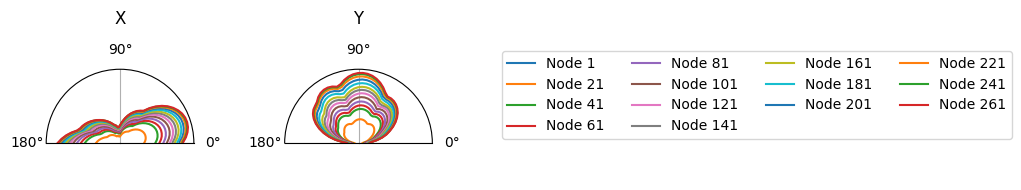

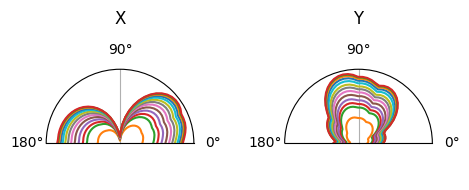

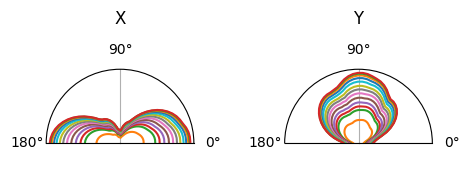

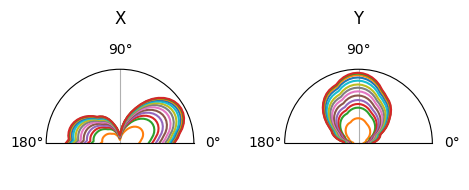

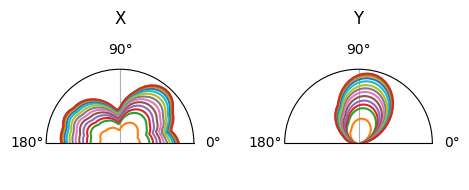

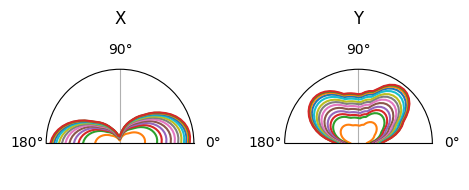

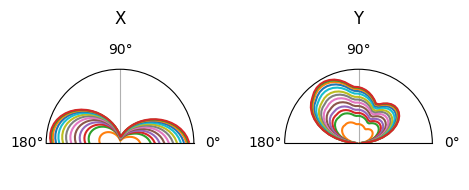

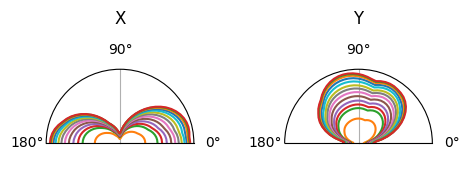

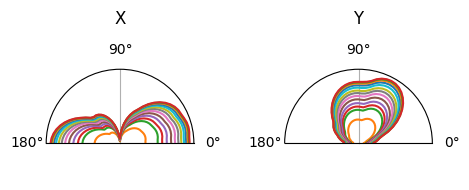

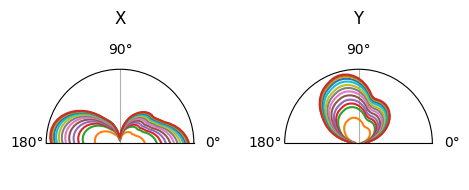

In [83]:
first_plot = True
for ethqke_name in earthquakes_data:
    with open('earthquakes_tha_{eth}.txt'.format(eth=ethqke_name), 'rb') as handle:
        earthquakes_tha = pickle.loads(handle.read())

    #prepare data
    rads = np.deg2rad(np.array(theta_list_analysis))
    polar_data = {}
    for n in range(len(nodes_left_side)):
        polar_data[nodes_left_side[n]] = {
            'Xdisp': [],
            'Ydisp': []
        }
        for i in range(len(theta_list_analysis)):
            polar_data[nodes_left_side[n]]['Xdisp'].append(earthquakes_tha[theta_list_analysis[i]][nodes_left_side[n]]['max']['X']['displacement'])
            polar_data[nodes_left_side[n]]['Ydisp'].append(earthquakes_tha[theta_list_analysis[i]][nodes_left_side[n]]['max']['Y']['displacement'])

        #Normalize data between 0 and 1
        #xmax = np.max(np.array(polar_data[nodes_left_side[n]]['Xdisp']))
        #xmin = np.min(np.array(polar_data[nodes_left_side[n]]['Xdisp']))
        #ymax = np.max(np.array(polar_data[nodes_left_side[n]]['Ydisp']))
        #ymin = np.min(np.array(polar_data[nodes_left_side[n]]['Ydisp']))

        #for i in range(len(theta_list_analysis)):
        #    polar_data[nodes_left_side[n]]['Xdisp'][i] = (polar_data[nodes_left_side[n]]['Xdisp'][i]-xmin)/(xmax - xmin)
        #    polar_data[nodes_left_side[n]]['Ydisp'][i] = (polar_data[nodes_left_side[n]]['Ydisp'][i]-xmin)/(ymax - ymin)

    #plot data
    fig, (ax) = plt.subplots(1,2,subplot_kw={'projection': 'polar'}, figsize=(5,2))
    for n in range(len(nodes_left_side)):
        ax[0].plot(rads, polar_data[nodes_left_side[n]]['Xdisp'])
        ax[1].plot(rads, polar_data[nodes_left_side[n]]['Ydisp'], label='Node {node}'.format(node=nodes_left_side[n]))
        
        ax[0].set_thetamin(0)
        ax[0].set_thetamax(180)
        ax[1].set_thetamin(0)
        ax[1].set_thetamax(180)
        ax[0].set_rgrids([])
        ax[1].set_rgrids([])
        ax[0].title.set_text('X')
        ax[1].title.set_text('Y')

    #labels_legend = ['Time History Analysis', 'Orientation independent IM with CQC combination', 'Time History Analysis', 'Orientation dependent IM with CQC combination', 'Time History Analysis', 'Codes with CQC combination']
    #colors_legend = ['#D55E00', '#D55E00A0', '#CC79A7', '#CC79A7A0', '#0072B2', '#0072B2A0']
    #patch0 = mpatches.Patch(color=colors_legend[0], label=labels_legend[0])
    #patch1 = mpatches.Patch(color=colors_legend[1], label=labels_legend[1])
    #patch2 = mpatches.Patch(color=colors_legend[2], label=labels_legend[2])
    #patch3 = mpatches.Patch(color=colors_legend[3], label=labels_legend[3])
    #patch4 = mpatches.Patch(color=colors_legend[4], label=labels_legend[4])
    #patch5 = mpatches.Patch(color=colors_legend[5], label=labels_legend[5])
    #fig.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], ncols=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    if first_plot:
        first_plot = False
        fig.legend(ncols=4, bbox_to_anchor=(1.02, 0.5), loc='center left')


    fig.tight_layout(h_pad=0.0, w_pad=0.5)
    plt.savefig("./plots/Polar/polar_{eth}.svg".format(eth=ethqke_name))
    plt.show()